## **Contents**
-  [1.Importing Libraries](#1)
-  [2.Dataset Managament](#2)
-  [3.Creating Sequential Models](#3)
-  [4.GPU Results](#4)
-  [5.CPU Results](#5)

### **1.Importing Libraries** <a class="anchor" id="1"></a>

In [1]:
%matplotlib inline

import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader as DataLoader
from torch.utils.data import Dataset as Dataset

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")

n_layer = 2
dataset_size = 1000
test_dataset_size = 100
batch_size = 50
seq_len = 50
epoch = 50
log_idx = int(epoch/5)

### **2.Dataset Managament** <a class="anchor" id="2"></a>

In [2]:
class dataset(Dataset):
    def __init__(self,dataset_size,seq_len):
        self.func = lambda x : np.sin(x)
        self.dataset_size = dataset_size
        self.seq_len = seq_len
    
    def __getitem__(self,idx):
        x = np.array([x for x in range(idx,idx+self.seq_len*2)])/10
        y = self.func(x) + np.random.rand(self.seq_len*2,)/5
        
        return torch.FloatTensor(y[:-1*self.seq_len]) , torch.FloatTensor(y[-1*self.seq_len:])

    def __len__(self):
        return self.dataset_size

train_dataset = dataset(dataset_size,seq_len)
train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=16)

test_dataset = dataset(dataset_size = test_dataset_size,seq_len = test_dataset_size)
test_dataloader = DataLoader(test_dataset,shuffle=False,batch_size=1)


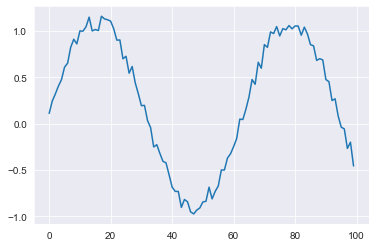

In [3]:
a = next(iter(test_dataloader))[0].numpy()
sns.lineplot(x = [i for i in range(len(a[0]))],y = a[0])
plt.show()

### **3.Creating Sequential Models** <a class="anchor" id="3"></a>

In [4]:
class rnn(nn.Module):
    def __init__(self,n_layer,device):
        super().__init__()
        self.device = device
        self.n_layer = n_layer
        self.rnn_block = nn.RNN(1,64,self.n_layer,batch_first=True) # input_features , out_features , n_layers
        self.output = nn.Linear(64,1)
        
    def forward(self,x):
        hidden = torch.zeros((self.n_layer,x.shape[0],64)).to(self.device) # n_layers , batch_size , out_feature/hidden_size
        x , _ = self.rnn_block(x,hidden) # batch_size , seq_len , in_features
        return self.output(x)   
    
class lstm(nn.Module):
    def __init__(self,n_layer,device):
        super().__init__()
        self.device = device
        self.n_layer = n_layer
        self.lstm_block = nn.LSTM(1,64,self.n_layer,batch_first=True) # input_features , out_features , n_layers
        self.output = nn.Linear(64,1)
        
    def forward(self,x):
        hidden = (torch.zeros((self.n_layer,x.shape[0],64)).to(self.device),torch.zeros((self.n_layer,x.shape[0],64)).to(self.device)) # n_layers , batch_size , out_feature/hidden_size
        x , _ = self.lstm_block(x,hidden) # batch_size , seq_len , in_features
        return self.output(x)   

class gru(nn.Module):
    def __init__(self,n_layer,device):
        super().__init__()
        self.device = device
        self.n_layer = n_layer
        self.gru_block = nn.GRU(1,64,self.n_layer,batch_first=True) # input_features , out_features , n_layers
        self.output = nn.Linear(64,1)
        
    def forward(self,x):
        hidden = torch.zeros((self.n_layer,x.shape[0],64)).to(self.device) # n_layers , batch_size , out_feature/hidden_size
        x , _ = self.gru_block(x,hidden) # batch_size , seq_len , in_features
        return self.output(x)   

models = ['RNN','LSTM','GRU']

lr = 0.01
criterion = nn.MSELoss()

model_losses = []
model_times = []
model_predictions = []


In [5]:
def model_results(model_name,lr,criterion,device,log_idx,epoch,train_dataloader,test_dataloader,n_layer,test_dataset_size):
    
    #Initializing models
    if device == 'cuda':
        torch.cuda.empty_cache()
    if model_name == 'RNN':
        model = rnn(n_layer,device)
    elif model_name == 'LSTM':
        model = lstm(n_layer,device)
    elif model_name == 'GRU':
        model = gru(n_layer,device)
    
    model.to(device)
    optimizer = optim.SGD(model.parameters(),lr = lr)

    loop_times = [[],[]] # training , validation
    prediction_history = [[],[],[]] # input , actual , predicted
    loss_history = [[],[]]
    
    for e in range(epoch):
        start = time.time()
        for batch_idx , (x ,y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            x , y = x.view((-1,x.shape[1],1)).to(device) , y.reshape((-1,x.shape[1])).to(device)
            y_pred = model(x).to(device)
            # Calculating Loss
            loss = criterion(y_pred.reshape(-1,y_pred.shape[1]),y)
            loss.backward()
            optimizer.step()
            loss_history[0].append(float(loss.detach()))
            
        loop_times[0].append(time.time()-start)
        start = time.time()
        
        with torch.no_grad():
            x , y = next(iter(test_dataloader))
            x , y = x.view((-1,x.shape[1],1)).to(device) , y.numpy()
            predicted = model(x)[0].cpu().detach().numpy()
            x = x[0].cpu().detach().numpy()
            prediction_history[0].append(x)
            prediction_history[1].append(y)
            prediction_history[2].append(predicted)
        
        loop_times[1].append(time.time()-start)
        # Saving the model progress
        loss_history[1].append(sum(loss_history[0][-1*batch_idx:])/batch_idx)
        torch.save(model.state_dict(),model_name)
        if e%log_idx == 0:

            #Log for e+1th epoch
            print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
            print(f'LOSS for EPOCH {e+1} TRAIN LOSS : {loss_history[1][-1]}',end = '\n')
            print('---------------------------------------------------------------------------------------------')
    
    training_time = sum(loop_times[0])/len(loop_times[0])
    testing_time = sum(loop_times[1])/len(loop_times[1])
    print(f'Training Time Average per Epoch : {training_time}')
    print(f'Testing Time Average per Epoch : {testing_time}')
    
    plt.title('Loss per Batch Size')
    sns.lineplot(x=[i for i in range(len(loss_history[0]))],y=loss_history[0])
    plt.show()
    plt.title('Loss per Epoch')
    sns.lineplot(x=[i for i in range(len(loss_history[1]))],y=loss_history[1])
    plt.show()
    
    x , y = next(iter(test_dataloader))
    x , y = x.view((-1,x.shape[1],1)).to(device) , y.numpy()
    predicted = model(x)[0].cpu().detach().numpy()
    x = x[0].cpu().detach().numpy()

    fig = plt.figure()
    plt.figure(figsize=(15,8))
    plt.title('Final Test prediction')
    sns.lineplot(x = [i for i in range(test_dataset_size)],y = x.reshape(test_dataset_size,),label = 'Input')
    end_point = x.reshape(test_dataset_size,)[-1:]
    sns.lineplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,y[0]),label = 'Ground Truth')
    sns.lineplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,predicted.reshape(test_dataset_size,)),linestyle='dotted',label='Predicted')
    plt.show()
    
    fig = plt.figure()
    plt.figure(figsize=(15,8))
    plt.title('Final Test prediction')
    sns.scatterplot(x = [i for i in range(test_dataset_size)],y = x.reshape(test_dataset_size,))
    sns.scatterplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,y[0]),label = 'Ground Truth')
    sns.scatterplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,predicted.reshape(test_dataset_size,)),linestyle='dotted',label='Predicted')
    plt.show()
    
    e = 0
    diff = int(len(prediction_history[0])/5)
    for i,j,k in zip(prediction_history[0][::diff],prediction_history[1][::diff],prediction_history[2][::diff]):
        e = e + 1
        fig = plt.figure(figsize=(15,8))
        plt.title(f'Epoch : {e*diff}')
        sns.lineplot(x = [i for i in range(test_dataset_size)],y = i.reshape(test_dataset_size,),label = 'Input')
        end_point = i.reshape(test_dataset_size,)[-1:]
        sns.lineplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,j[0]),label = 'Ground Truth')
        sns.lineplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,k.reshape(test_dataset_size,)),linestyle='dotted',label='Predicted')
        plt.show()
        
    return (training_time , testing_time) , loss_history , prediction_history

### **4.GPU Results** <a class="anchor" id="4"></a>

=======================================RNN============================================
---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 TRAIN LOSS : 0.3914348752267899
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 11-------------------------------------------
LOSS for EPOCH 11 TRAIN LOSS : 0.0942338143265055
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 21-------------------------------------------
LOSS for EPOCH 21 TRAIN LOSS : 0.09085004374144538
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 31-------------------------------------------
LOSS for EPOCH 31 TRAIN LOSS : 0.08867699875225944
-------------------------------------------------------------------

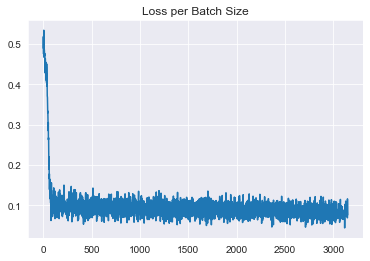

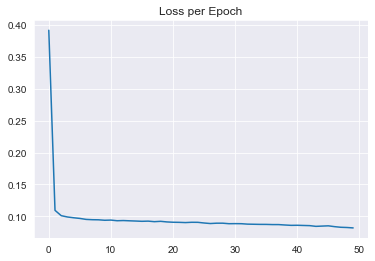

<Figure size 432x288 with 0 Axes>

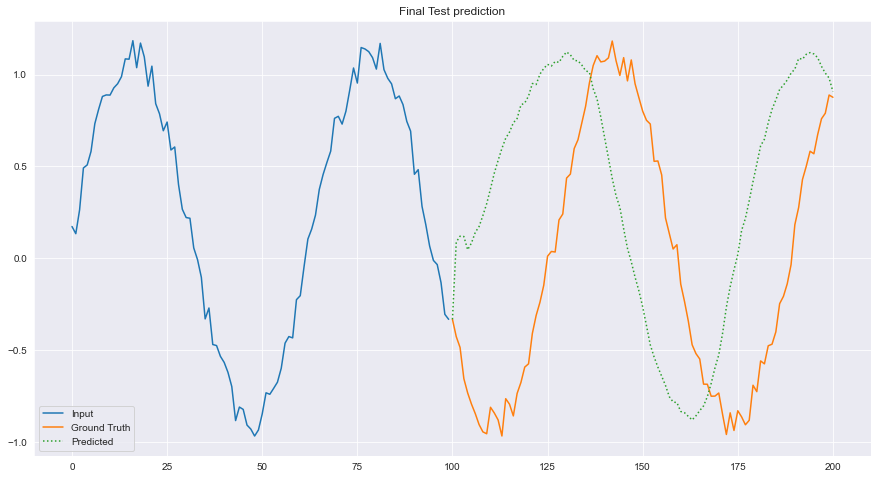

<Figure size 432x288 with 0 Axes>

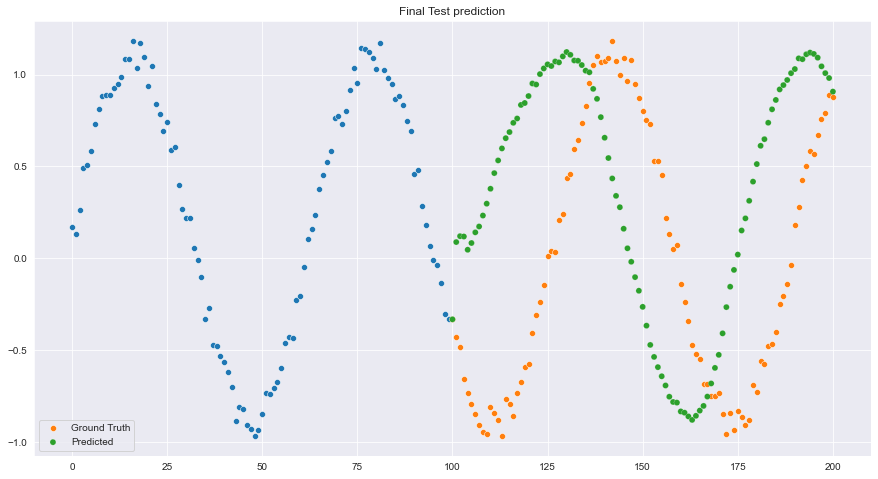

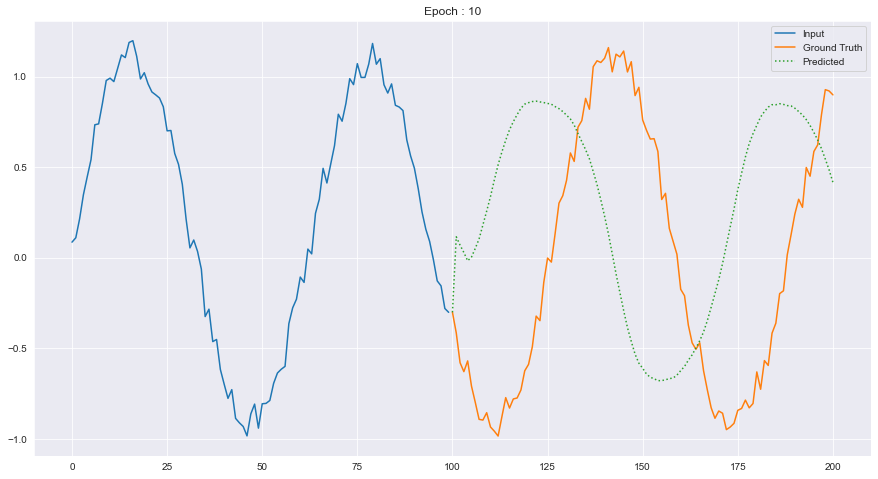

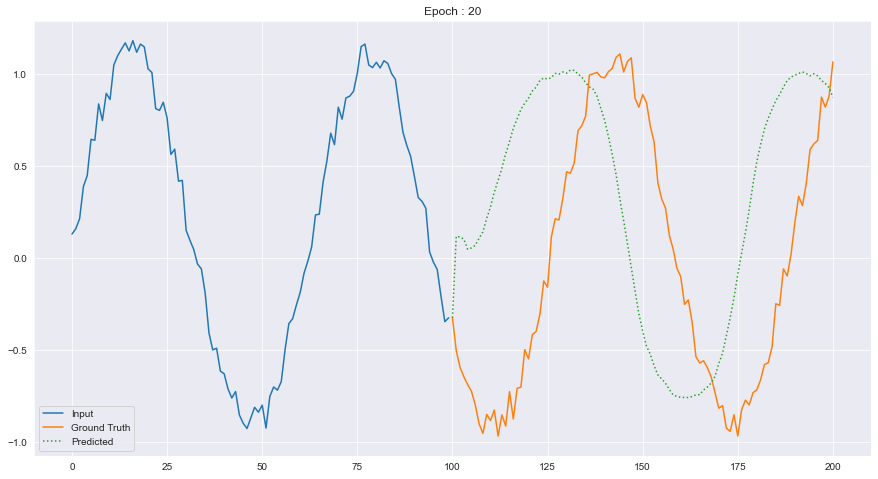

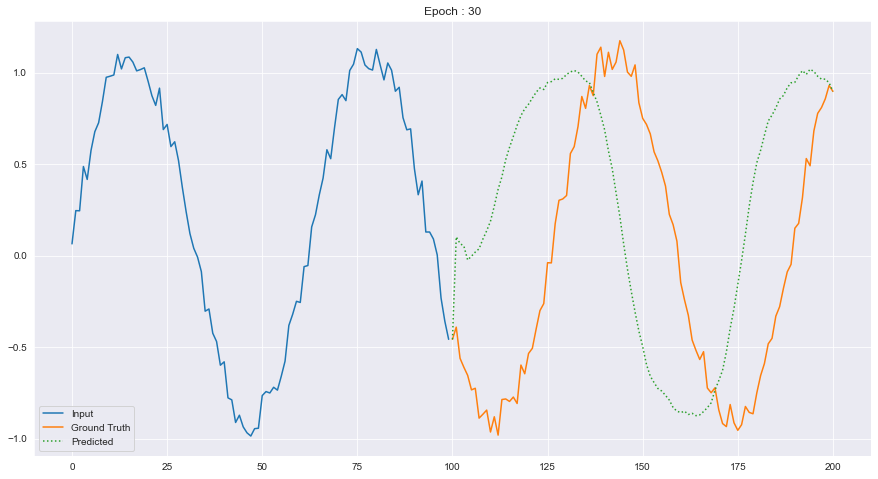

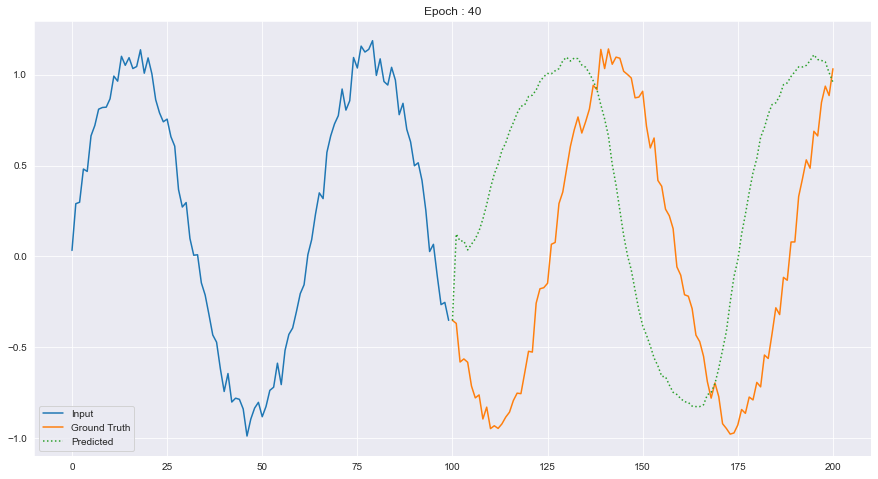

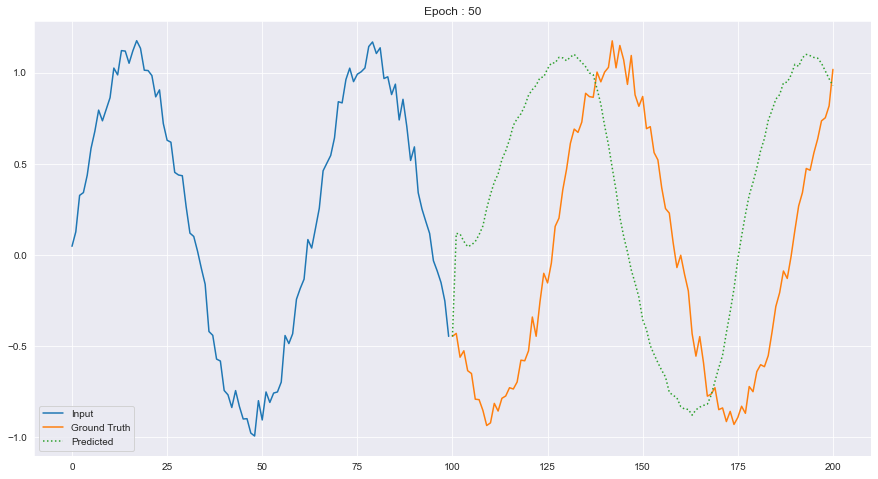

=======================================LSTM============================================
---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 TRAIN LOSS : 0.5079942427335247
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 11-------------------------------------------
LOSS for EPOCH 11 TRAIN LOSS : 0.35499093032652335
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 21-------------------------------------------
LOSS for EPOCH 21 TRAIN LOSS : 0.10681925521742913
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 31-------------------------------------------
LOSS for EPOCH 31 TRAIN LOSS : 0.10508058172079825
-----------------------------------------------------------------

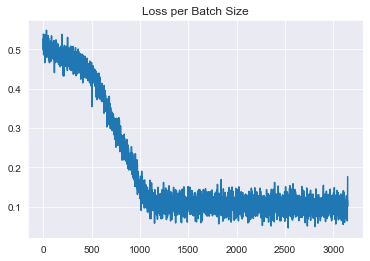

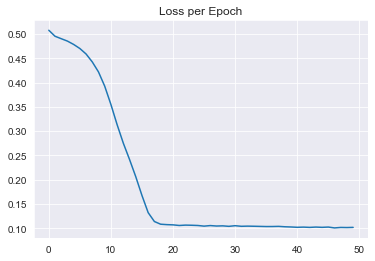

<Figure size 432x288 with 0 Axes>

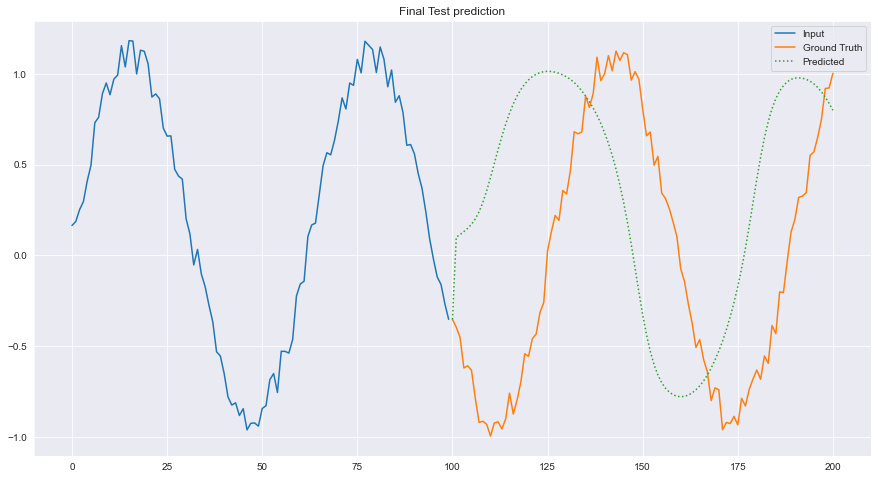

<Figure size 432x288 with 0 Axes>

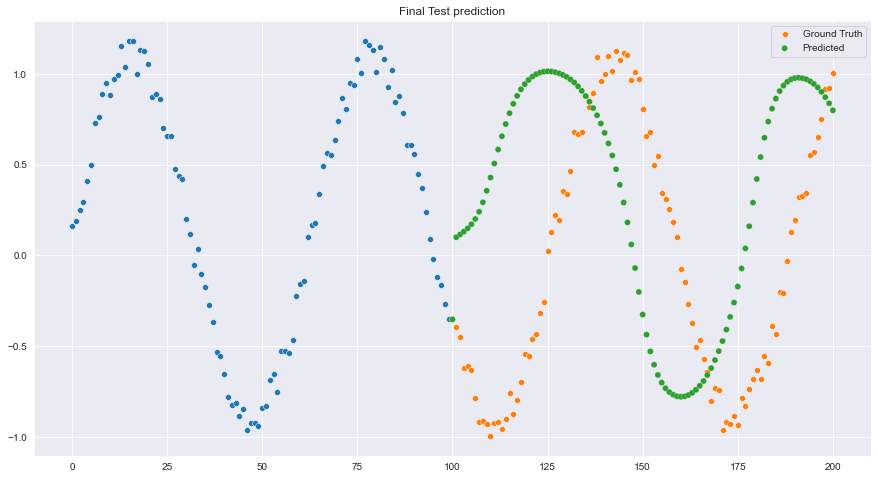

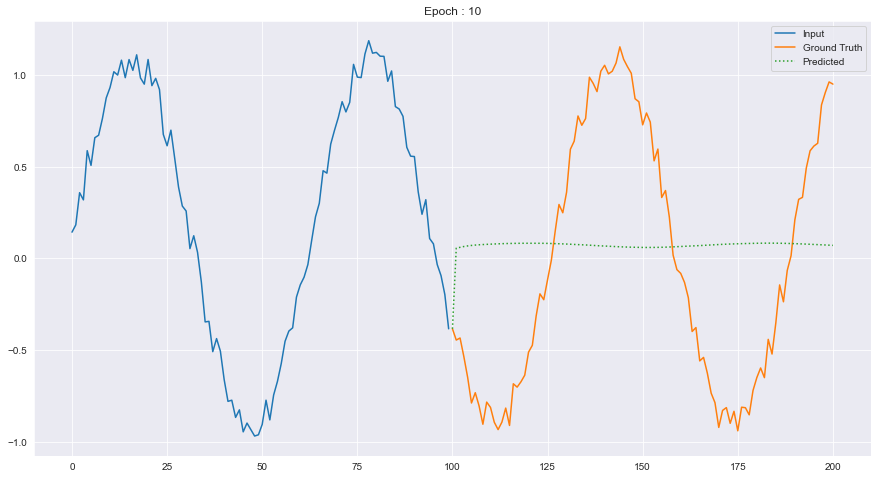

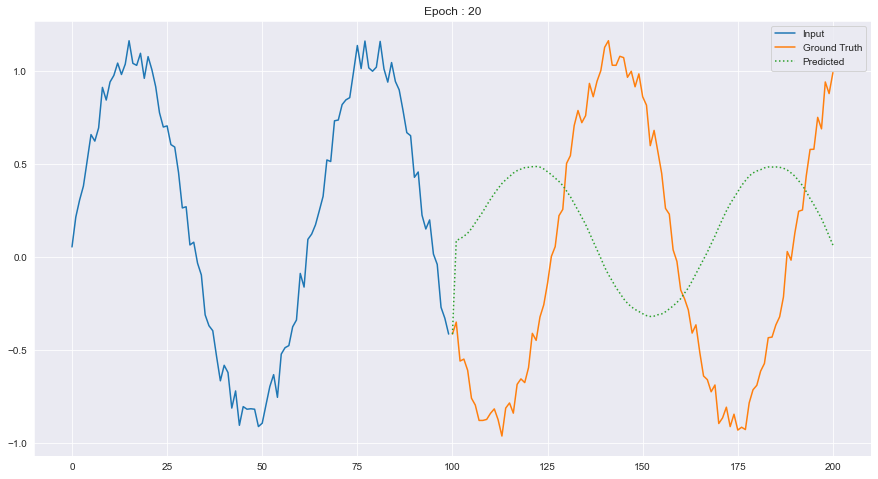

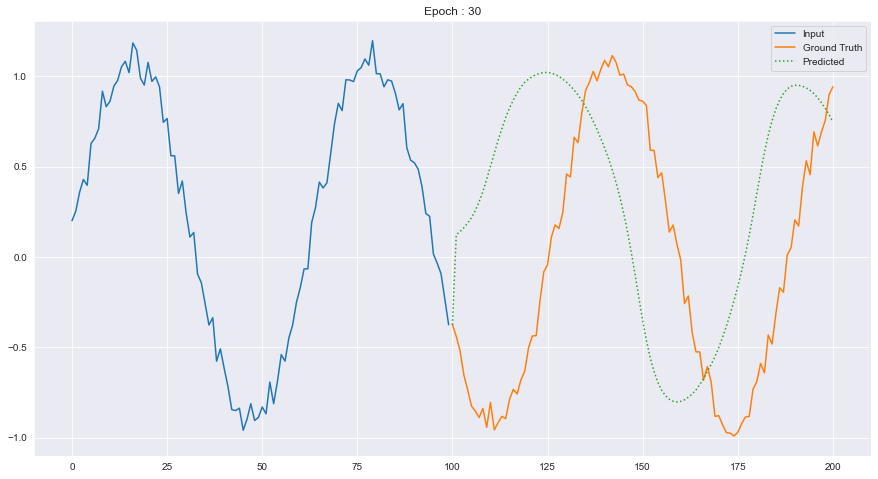

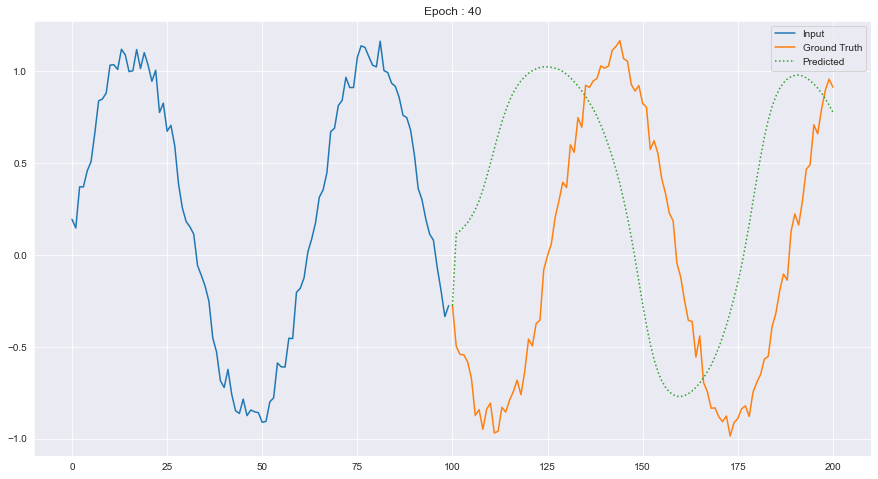

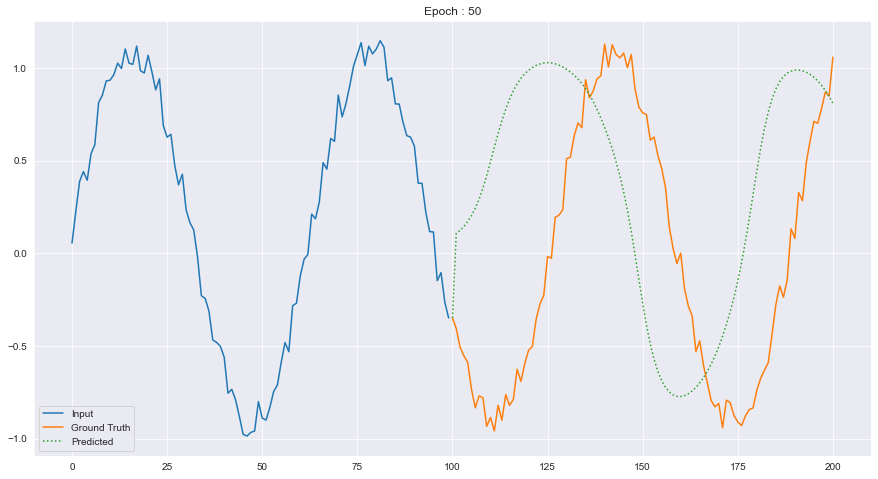

=======================================GRU============================================
---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 TRAIN LOSS : 0.47526781741649876
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 11-------------------------------------------
LOSS for EPOCH 11 TRAIN LOSS : 0.13997281318710697
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 21-------------------------------------------
LOSS for EPOCH 21 TRAIN LOSS : 0.09659828077400884
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 31-------------------------------------------
LOSS for EPOCH 31 TRAIN LOSS : 0.09609190158305629
-----------------------------------------------------------------

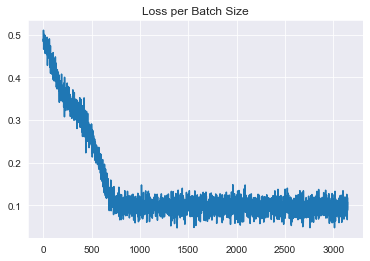

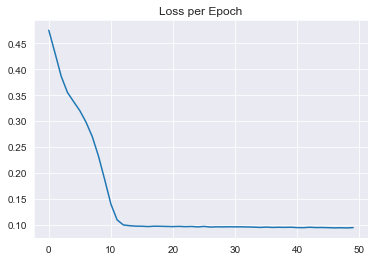

<Figure size 432x288 with 0 Axes>

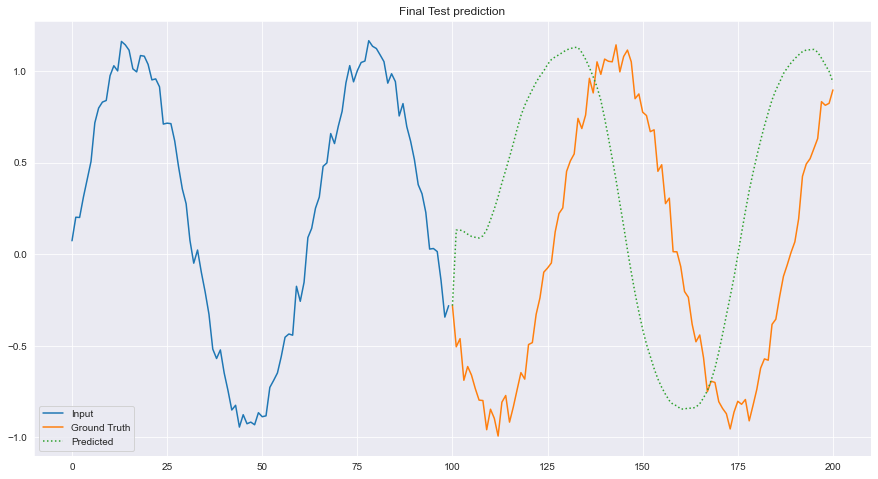

<Figure size 432x288 with 0 Axes>

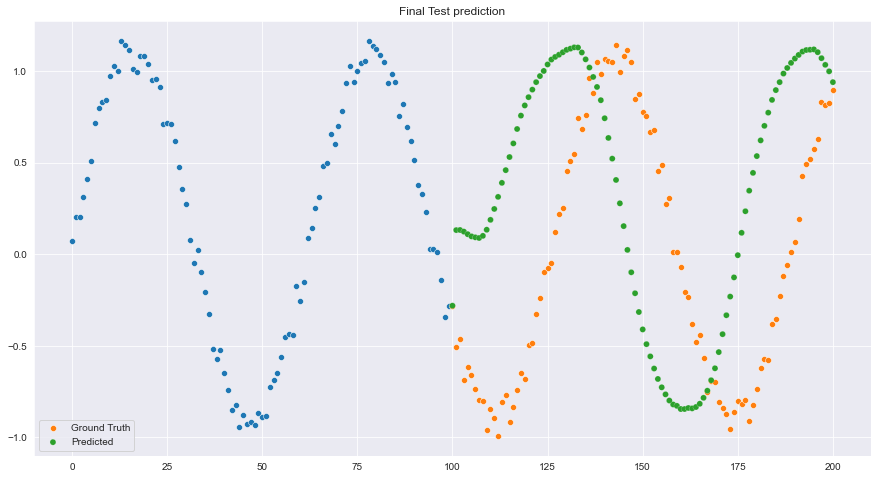

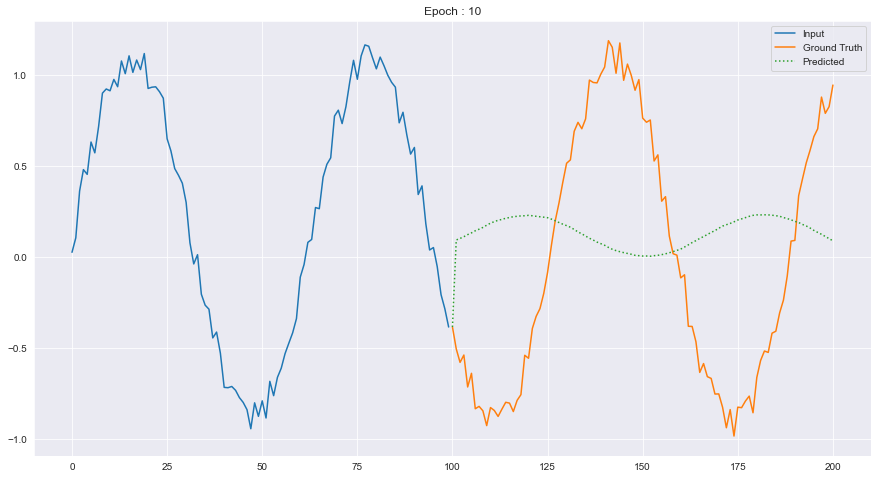

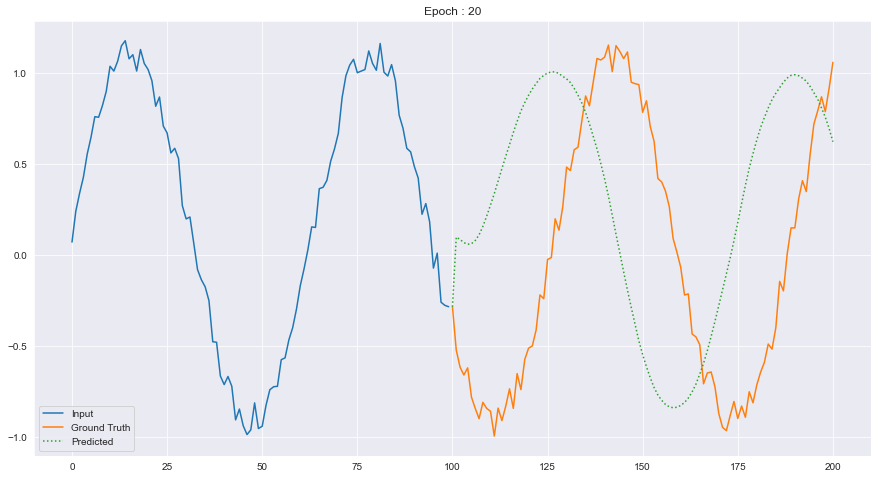

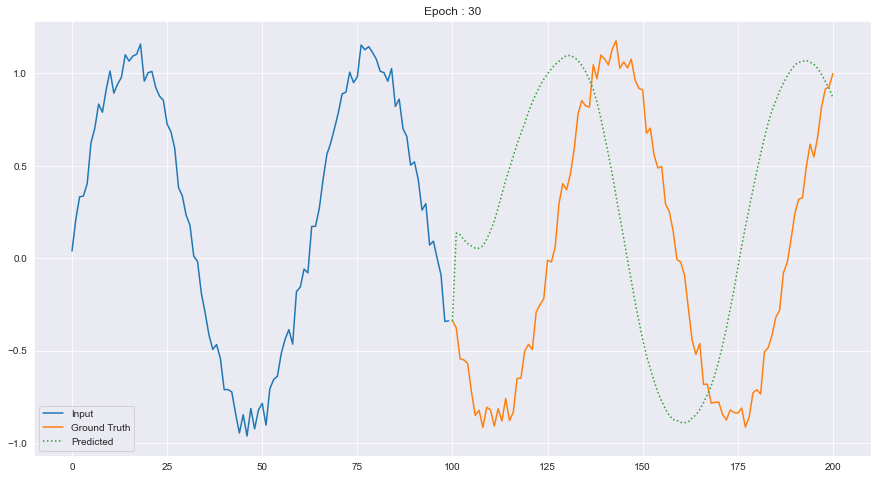

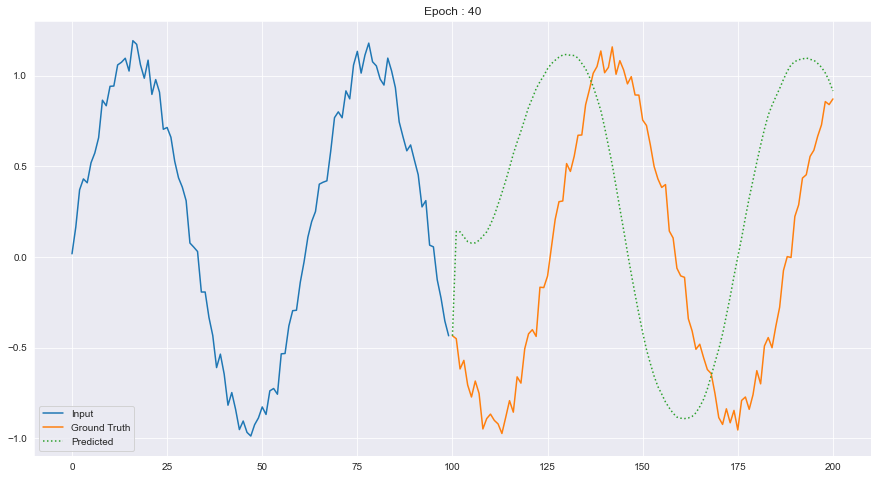

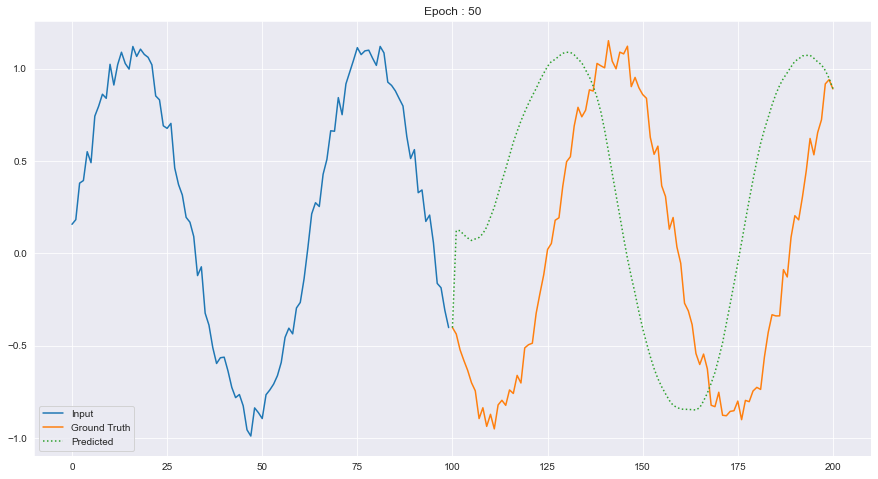

In [6]:
for model_name in models:
    device = 'cuda'
    print(f'======================================={model_name}============================================')
    (training_time , testing_time) , loss_history , prediction_history = model_results(model_name,lr,criterion,device,log_idx,epoch,train_dataloader,test_dataloader,n_layer,test_dataset_size)
    model_losses.append(loss_history)
    model_times.append([training_time,testing_time])
    model_predictions.append(prediction_history)

<Figure size 432x288 with 0 Axes>

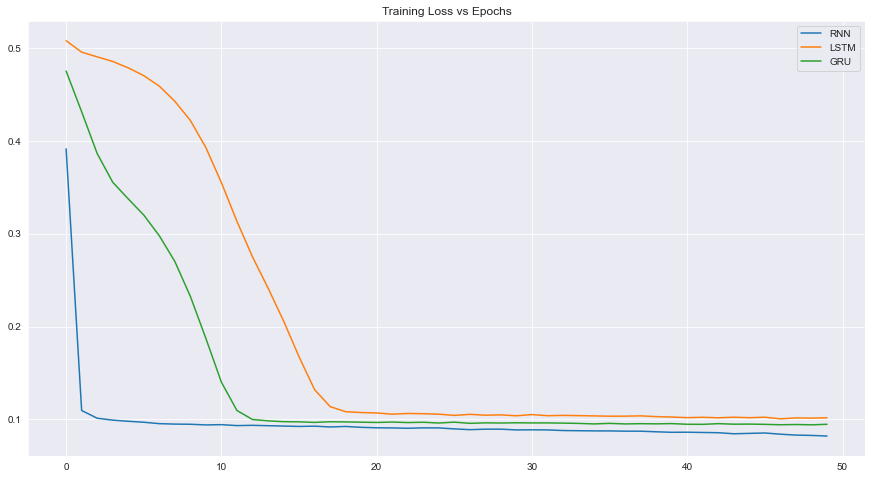

In [7]:
fig = plt.figure()
plt.figure(figsize=(15,8))

for i,name in zip(model_losses,models):
    plt.plot(i[1],label = name)


plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

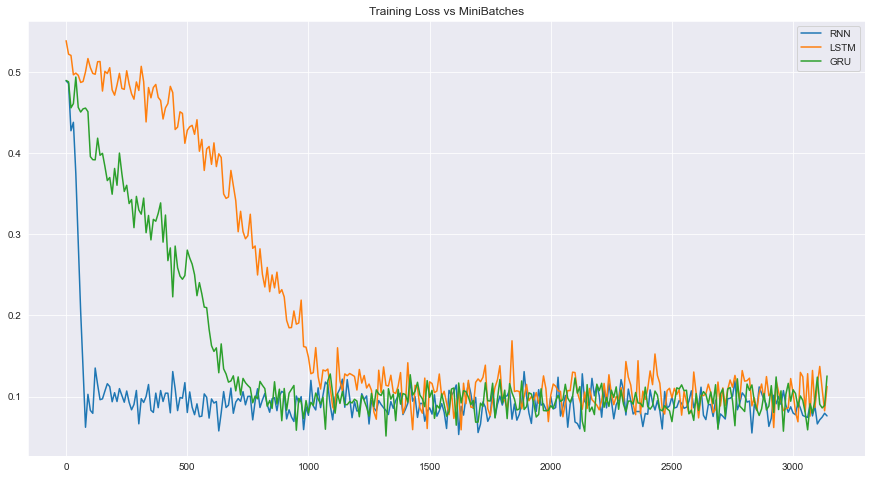

In [8]:
fig = plt.figure()
plt.figure(figsize=(15,8))

for i,name in zip(model_losses,models):
    plt.plot([i*10 for i in range(len(i[0][::10]))],i[0][::10],label = name)


plt.title('Training Loss vs MiniBatches')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

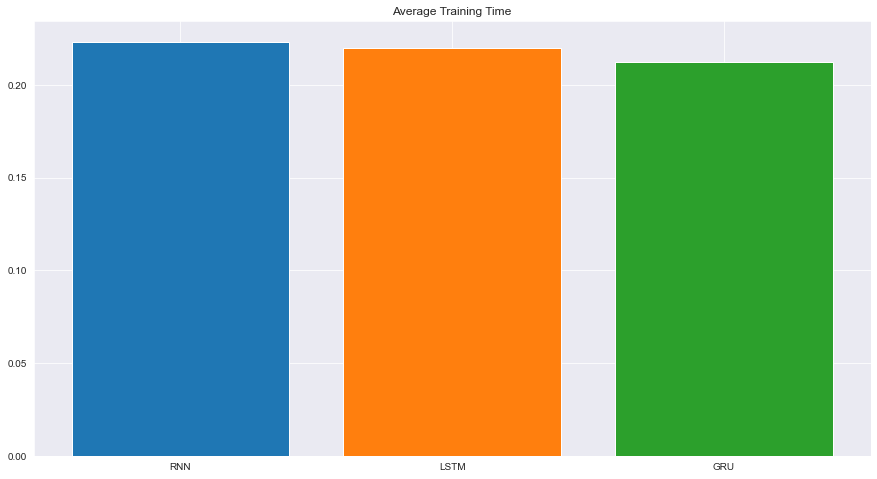

<Figure size 432x288 with 0 Axes>

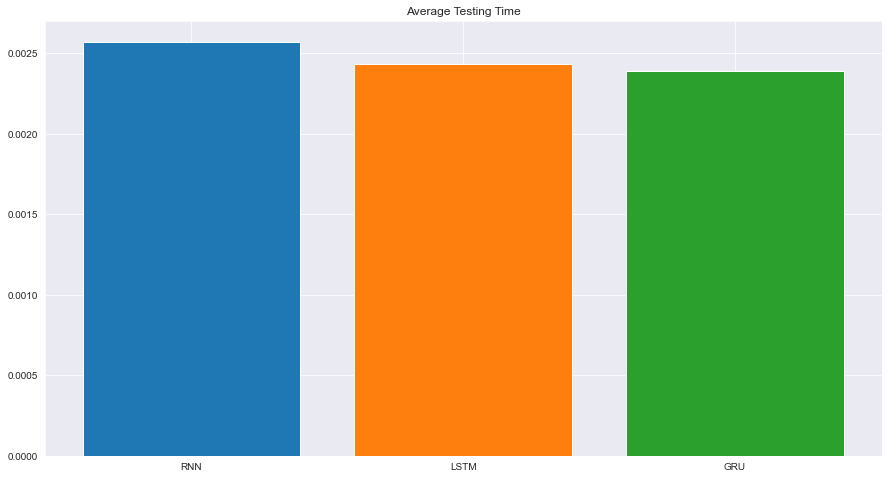

In [9]:
fig = plt.figure()
plt.figure(figsize=(15,8))
plt.title('Average Training Time')

for i in range(3):
    plt.bar([models[i]],model_times[i][0])

plt.show()

fig = plt.figure()
plt.figure(figsize=(15,8))
plt.title('Average Testing Time')

for i in range(3):
    plt.bar([models[i]],model_times[i][1])

plt.show()

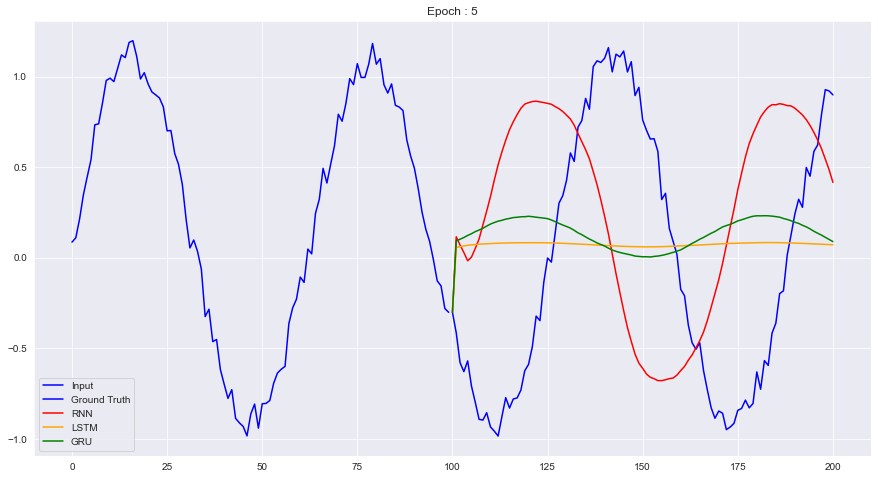

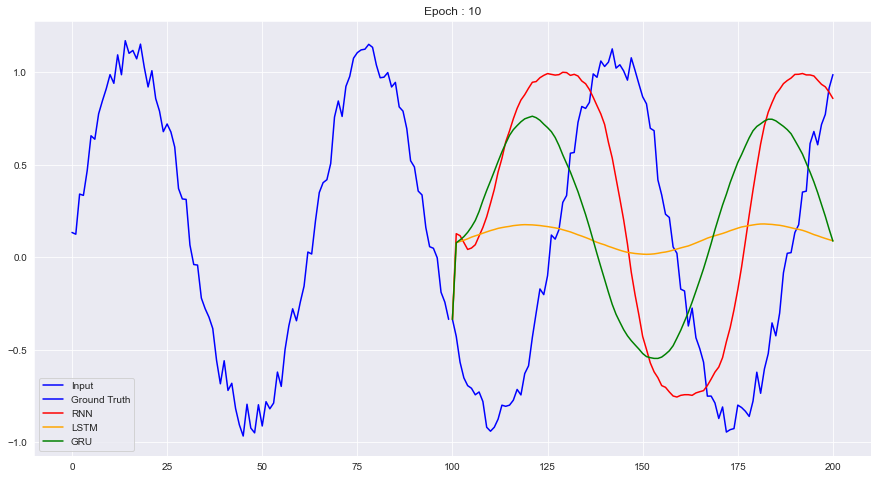

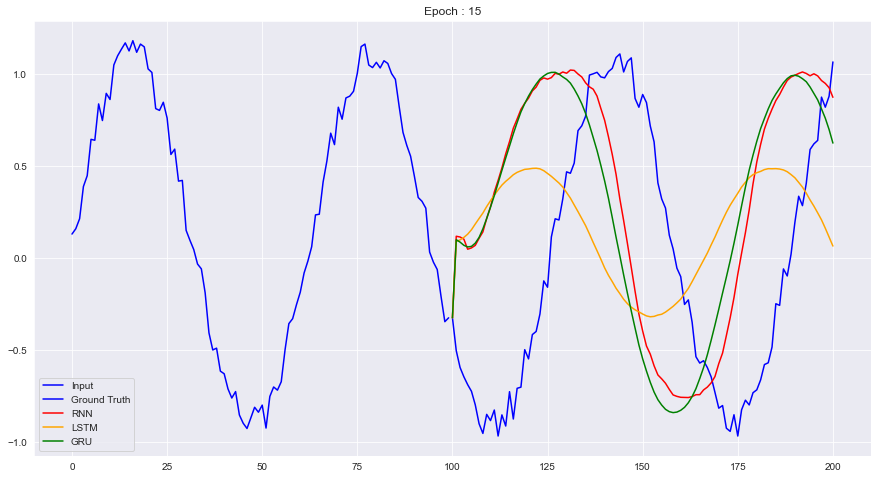

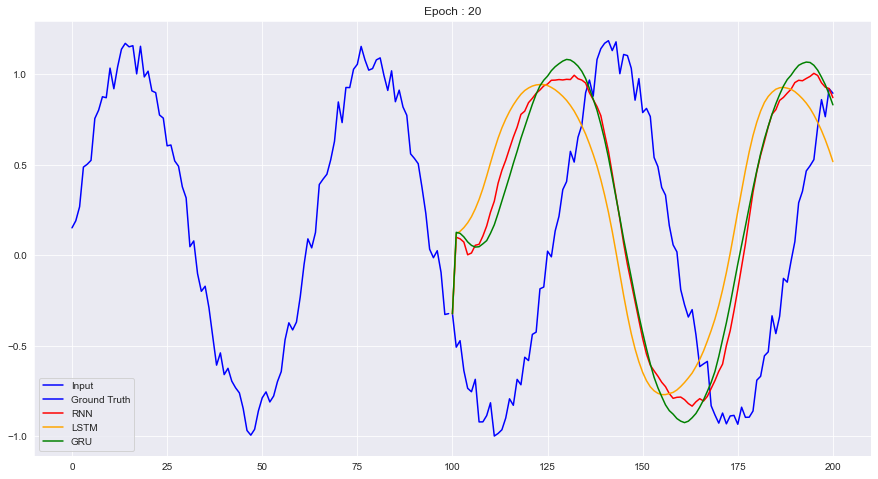

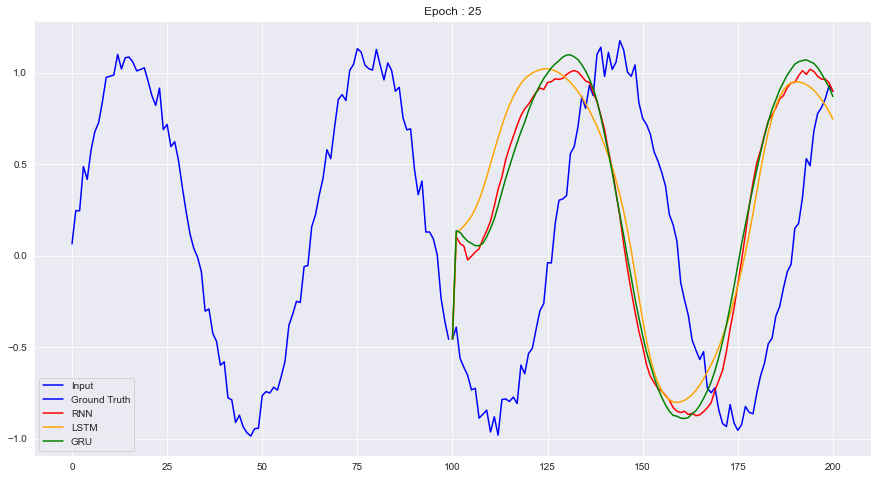

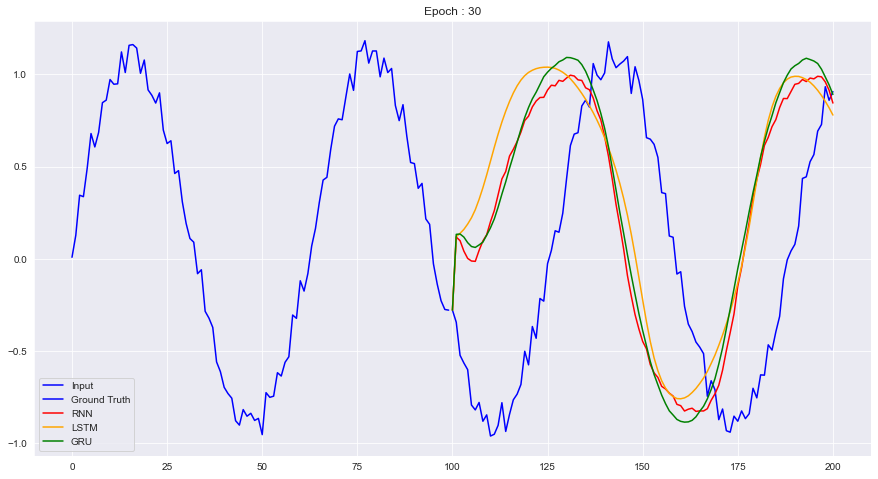

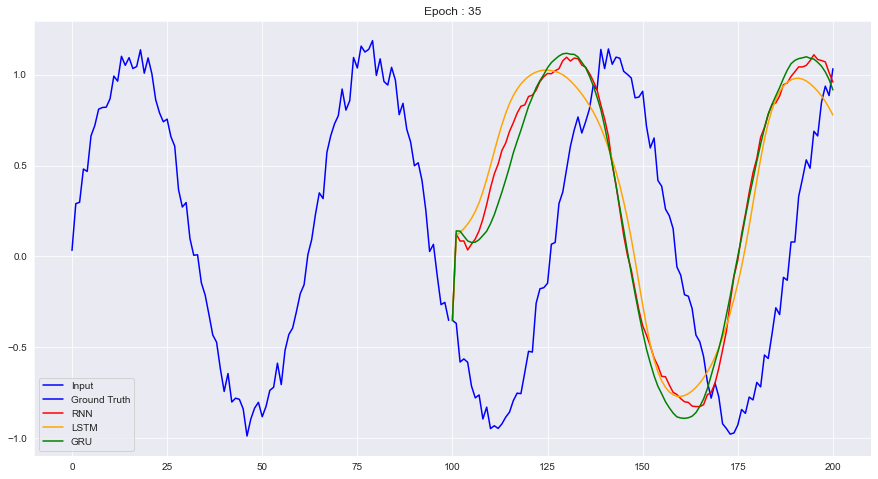

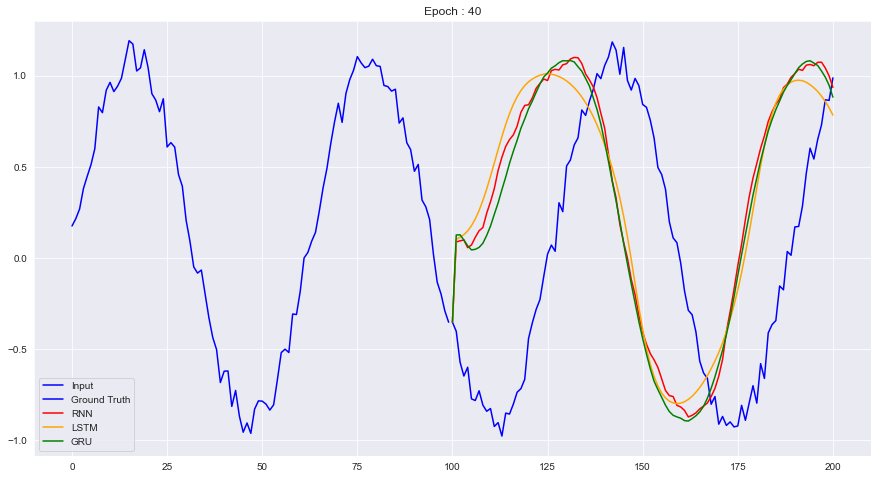

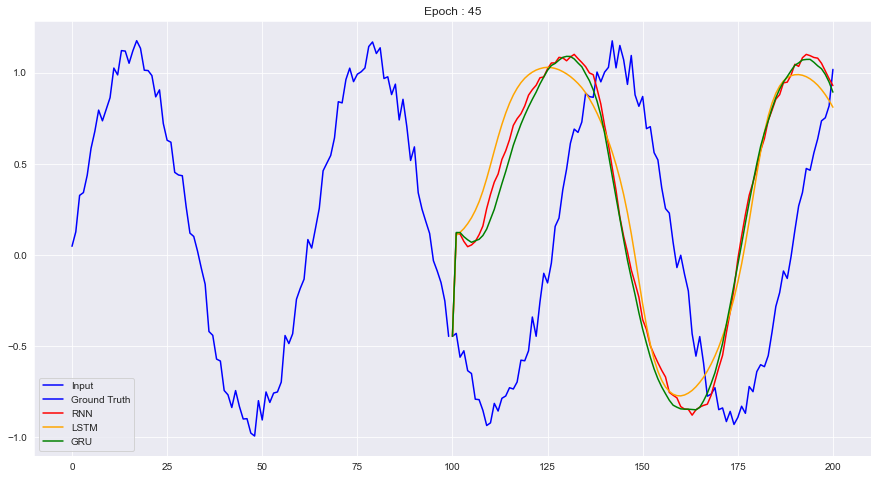

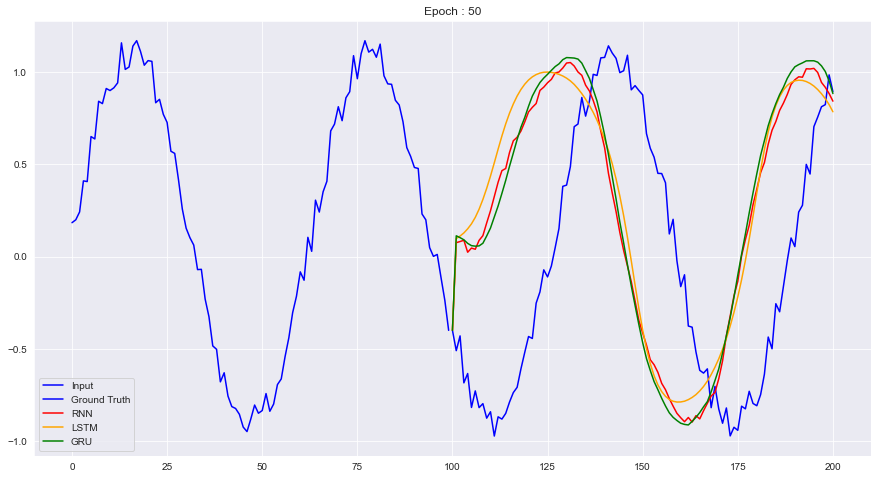

In [10]:
e = 0
prediction_len = len(model_predictions[0][0])
diff = int(prediction_len/10)

for nth_prediction in range(0,prediction_len,diff):
    e = e + 1
    fig = plt.figure(figsize=(15,8))
    plt.title(f'Epoch : {e*diff}')
    sns.lineplot(x = [i for i in range(test_dataset_size)],y = model_predictions[0][0][nth_prediction].reshape(test_dataset_size,),label = 'Input',color = 'blue')
    end_point = model_predictions[0][0][nth_prediction].reshape(test_dataset_size,)[-1:]
    sns.lineplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,model_predictions[0][1][nth_prediction][0]),label = 'Ground Truth',color = 'blue')
    for color , nth_model in zip(['red','orange','green'],[0,1,2]):
        sns.lineplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,model_predictions[nth_model][2][nth_prediction].reshape(test_dataset_size,)),linestyle='solid',label=f'{models[nth_model]}',color = color)
    plt.show()

### **5.CPU Results** <a class="anchor" id="5"></a>

=======================================RNN============================================
---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 TRAIN LOSS : 0.4650462558192591
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 11-------------------------------------------
LOSS for EPOCH 11 TRAIN LOSS : 0.09530027631309725
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 21-------------------------------------------
LOSS for EPOCH 21 TRAIN LOSS : 0.09205824671493422
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 31-------------------------------------------
LOSS for EPOCH 31 TRAIN LOSS : 0.09027905521854278
------------------------------------------------------------------

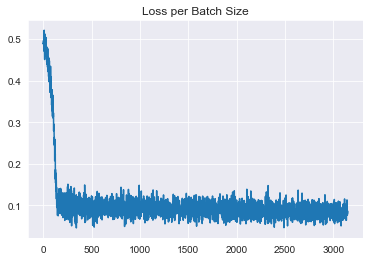

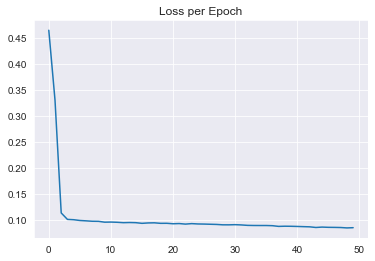

<Figure size 432x288 with 0 Axes>

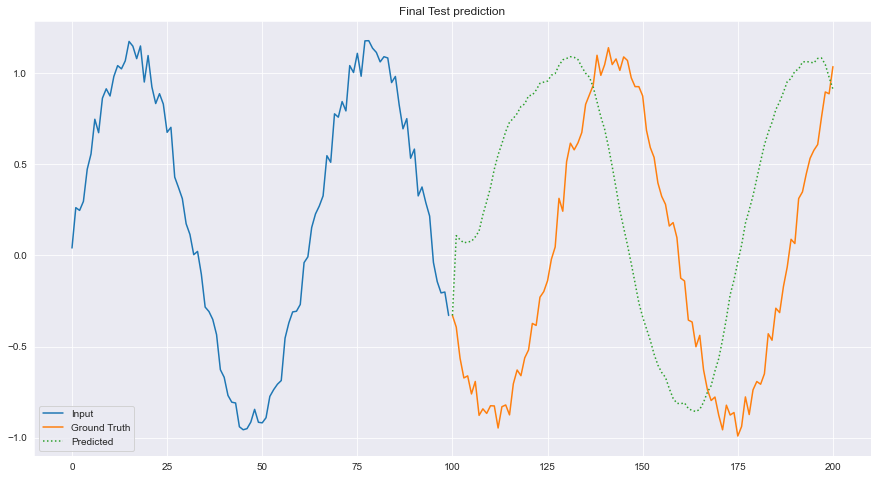

<Figure size 432x288 with 0 Axes>

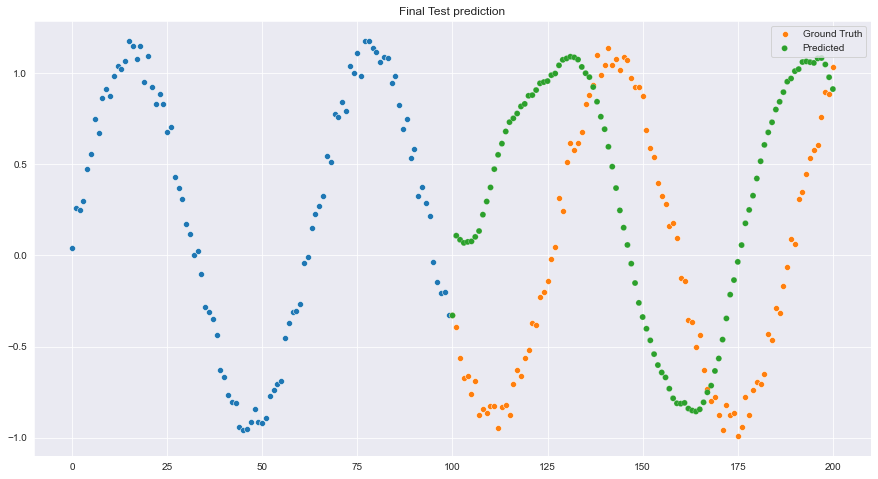

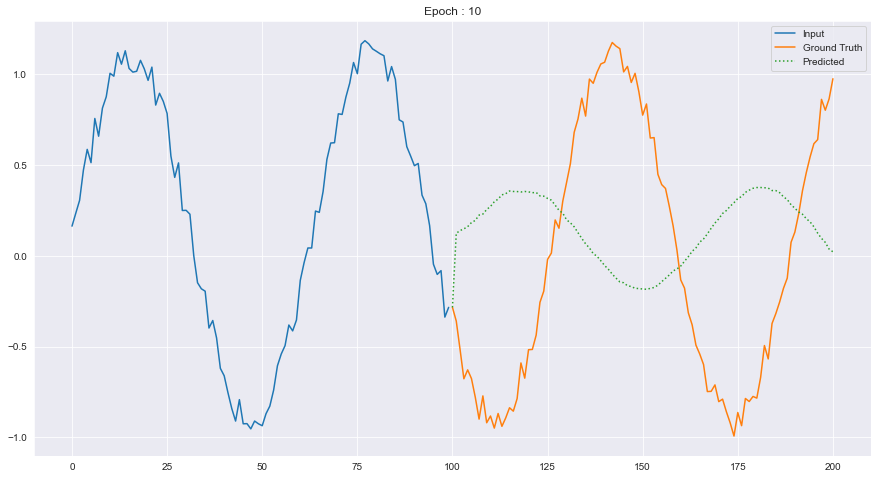

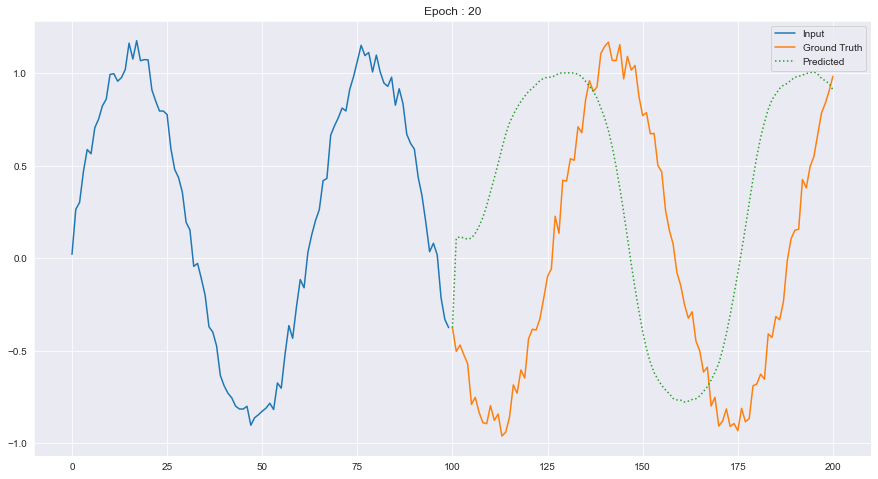

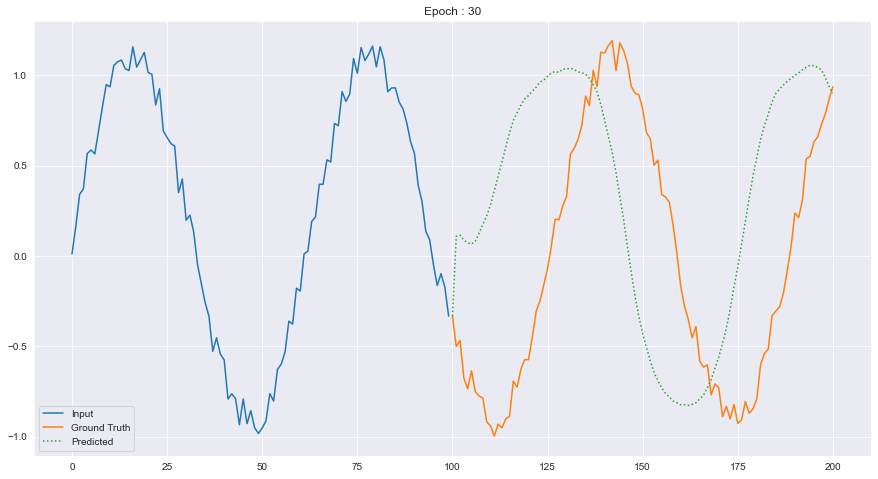

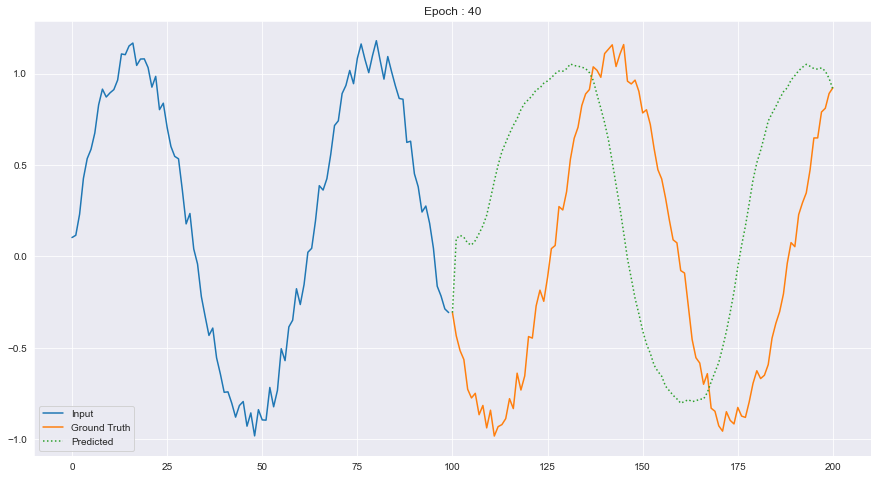

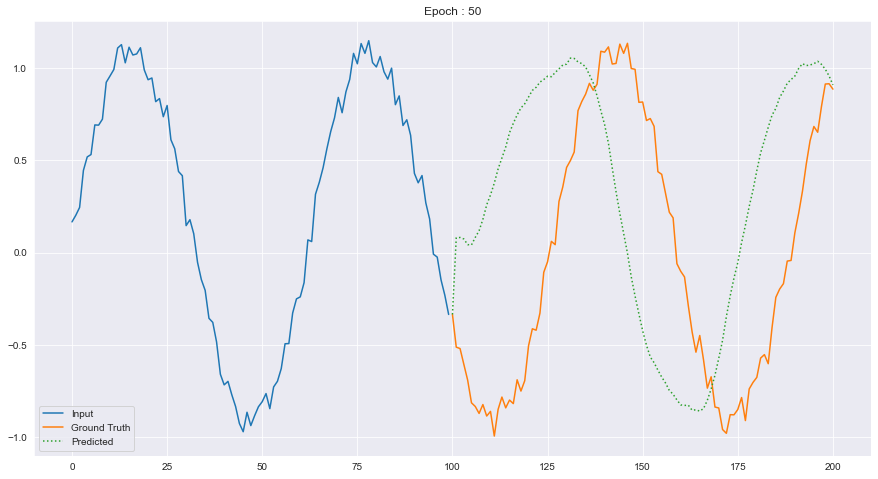

=======================================LSTM============================================
---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 TRAIN LOSS : 0.5028563987824225
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 11-------------------------------------------
LOSS for EPOCH 11 TRAIN LOSS : 0.4057939552491711
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 21-------------------------------------------
LOSS for EPOCH 21 TRAIN LOSS : 0.1103624451544977
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 31-------------------------------------------
LOSS for EPOCH 31 TRAIN LOSS : 0.10252984402881514
-------------------------------------------------------------------

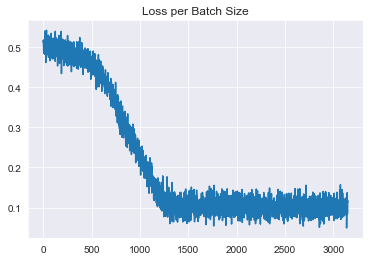

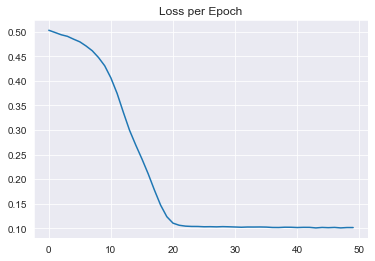

<Figure size 432x288 with 0 Axes>

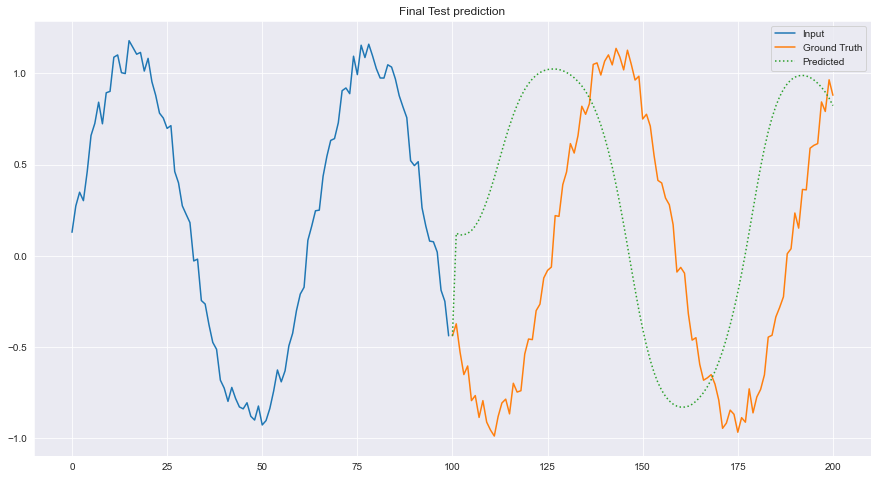

<Figure size 432x288 with 0 Axes>

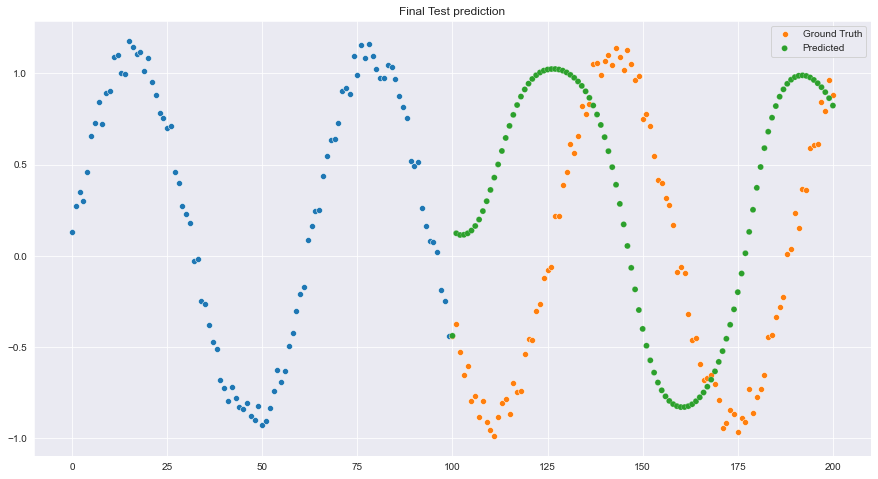

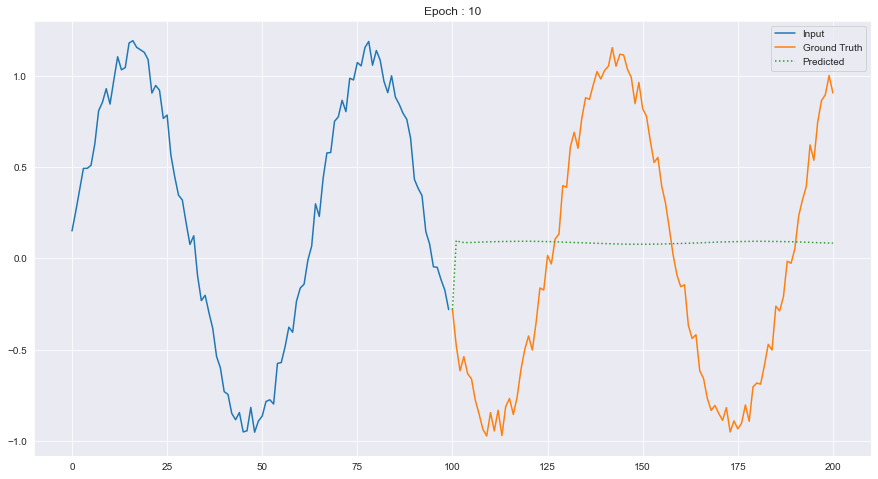

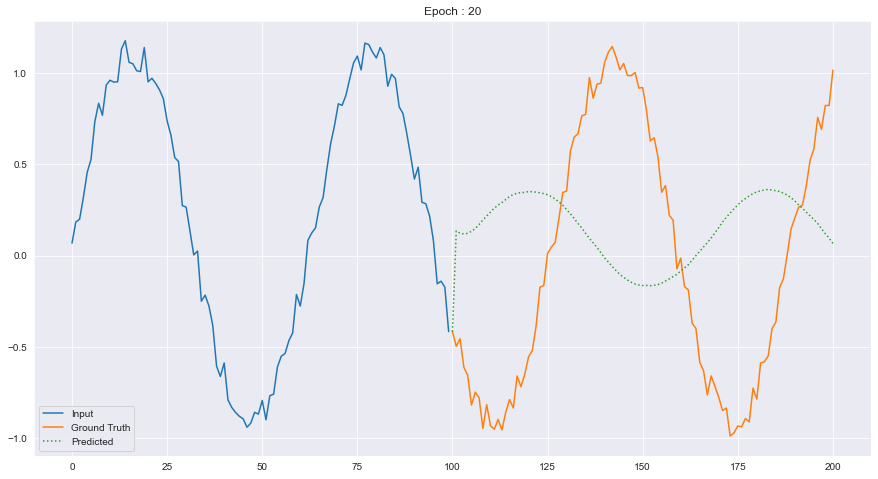

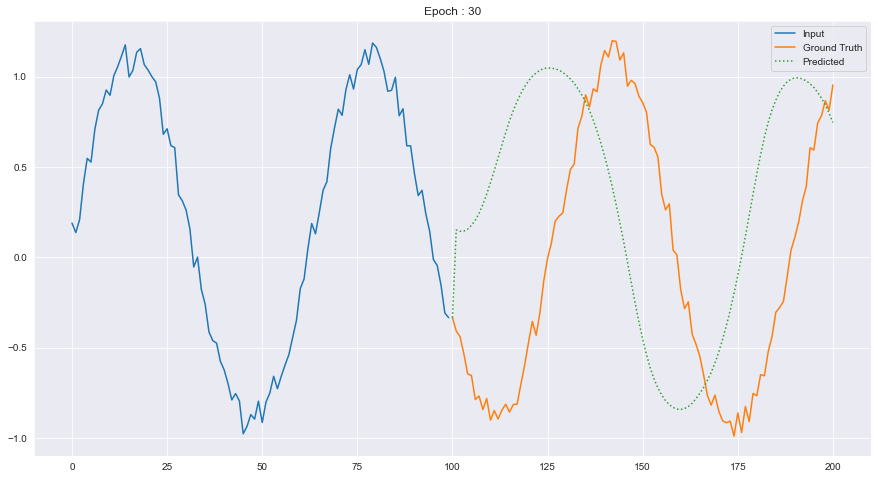

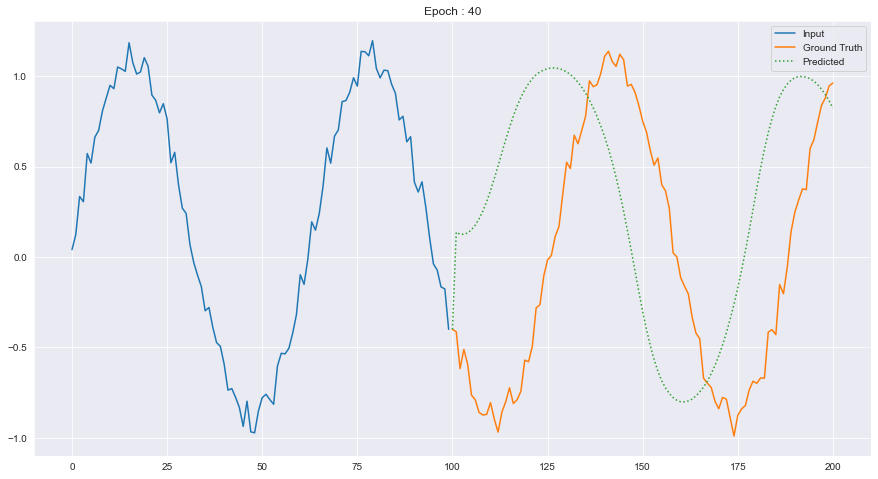

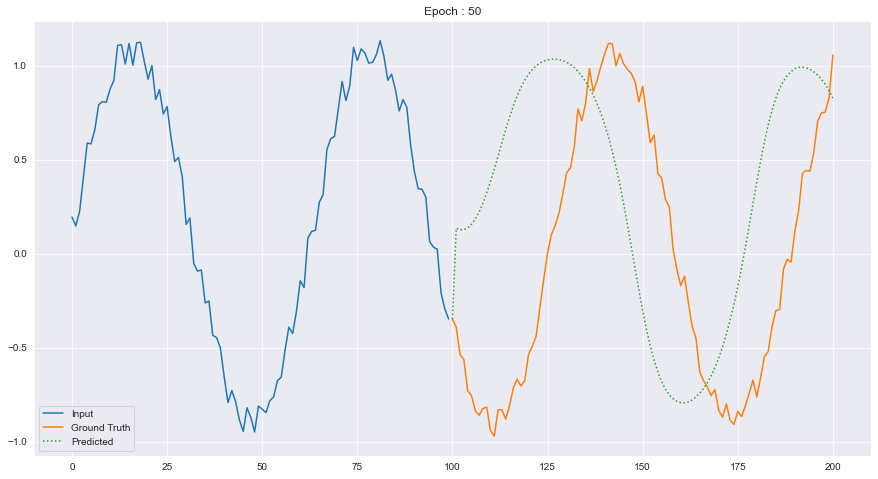

=======================================GRU============================================
---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 TRAIN LOSS : 0.4861598461866379
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 11-------------------------------------------
LOSS for EPOCH 11 TRAIN LOSS : 0.1503955957389647
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 21-------------------------------------------
LOSS for EPOCH 21 TRAIN LOSS : 0.09508481261230284
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 31-------------------------------------------
LOSS for EPOCH 31 TRAIN LOSS : 0.09438190561148428
-------------------------------------------------------------------

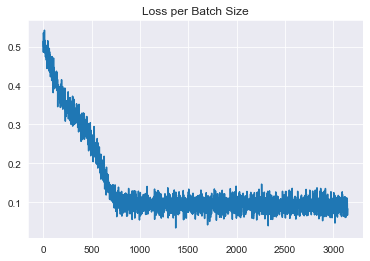

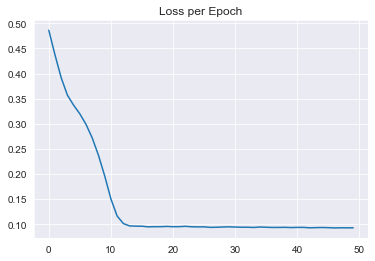

<Figure size 432x288 with 0 Axes>

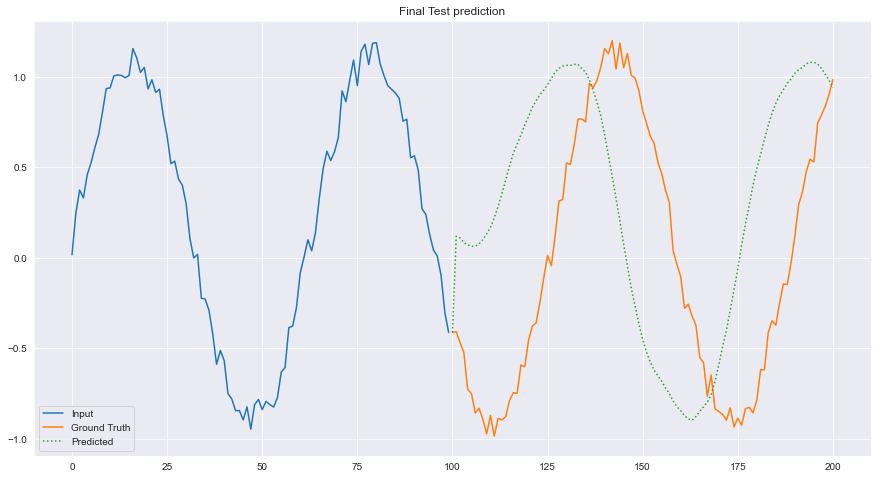

<Figure size 432x288 with 0 Axes>

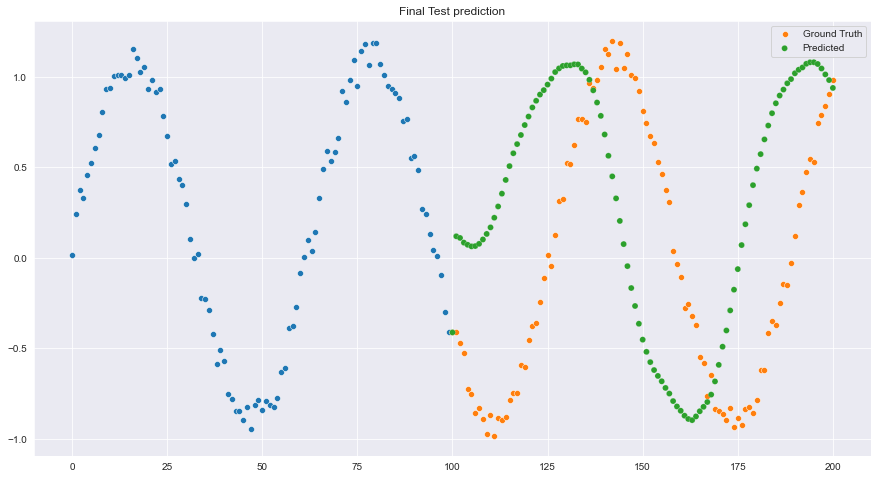

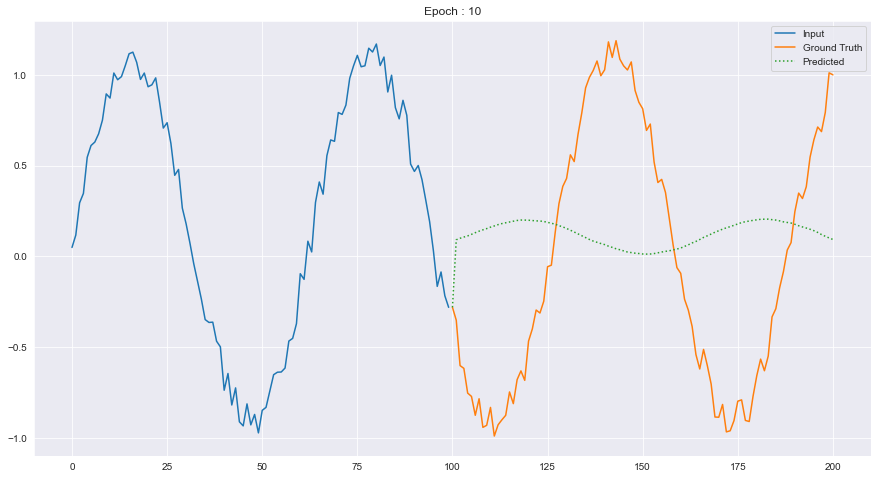

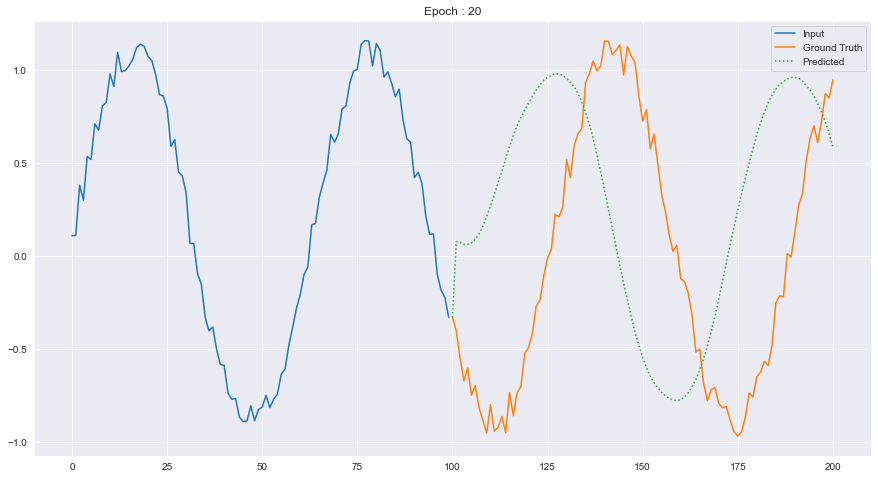

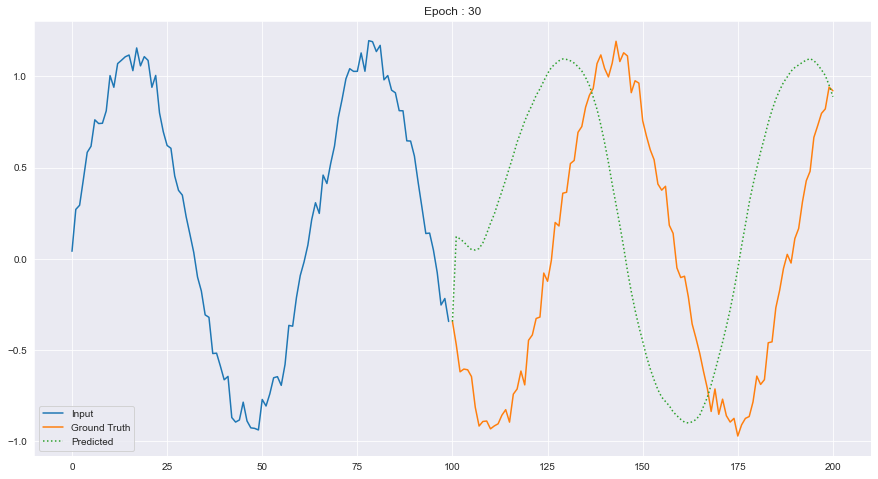

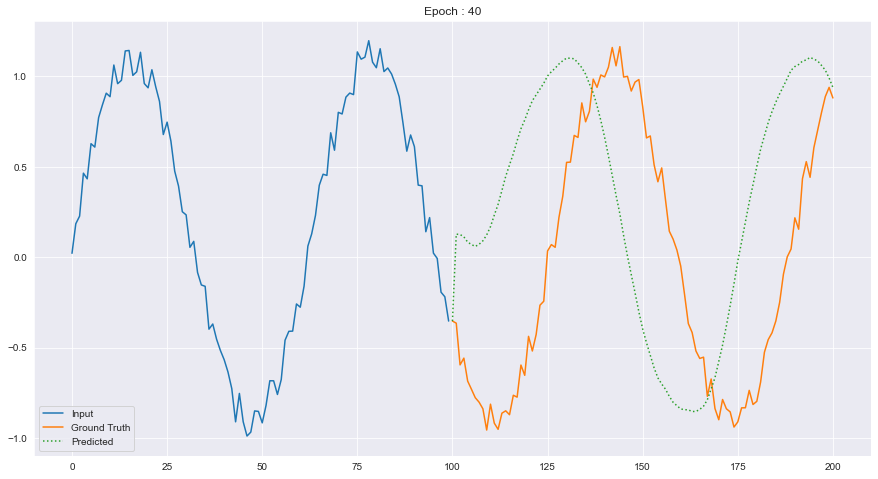

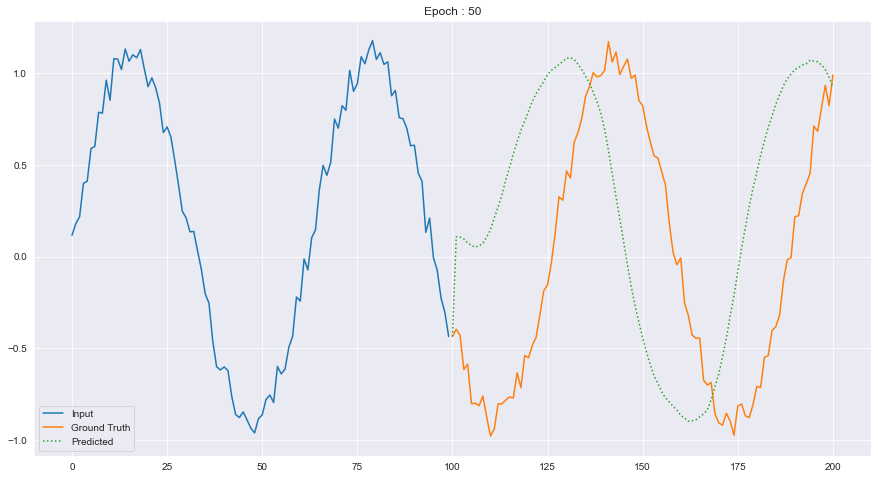

In [11]:
for model_name in models:
    device = 'cpu'
    print(f'======================================={model_name}============================================')
    (training_time , testing_time) , loss_history , prediction_history = model_results(model_name,lr,criterion,device,log_idx,epoch,train_dataloader,test_dataloader,n_layer,test_dataset_size)
    model_losses.append(loss_history)
    model_times.append([training_time,testing_time])
    model_predictions.append(prediction_history)

<Figure size 432x288 with 0 Axes>

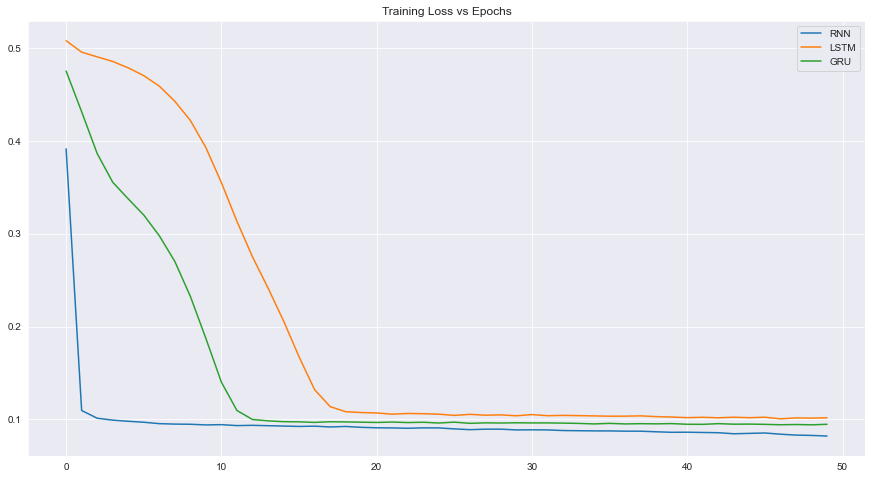

In [12]:
fig = plt.figure()
plt.figure(figsize=(15,8))

for i,name in zip(model_losses,models):
    plt.plot(i[1],label = name)


plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

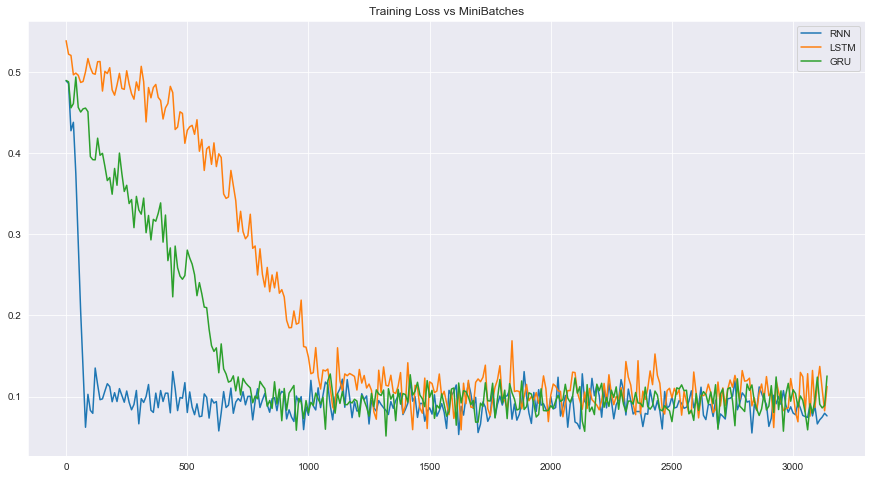

In [13]:
fig = plt.figure()
plt.figure(figsize=(15,8))

for i,name in zip(model_losses,models):
    plt.plot([i*10 for i in range(len(i[0][::10]))],i[0][::10],label = name)


plt.title('Training Loss vs MiniBatches')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

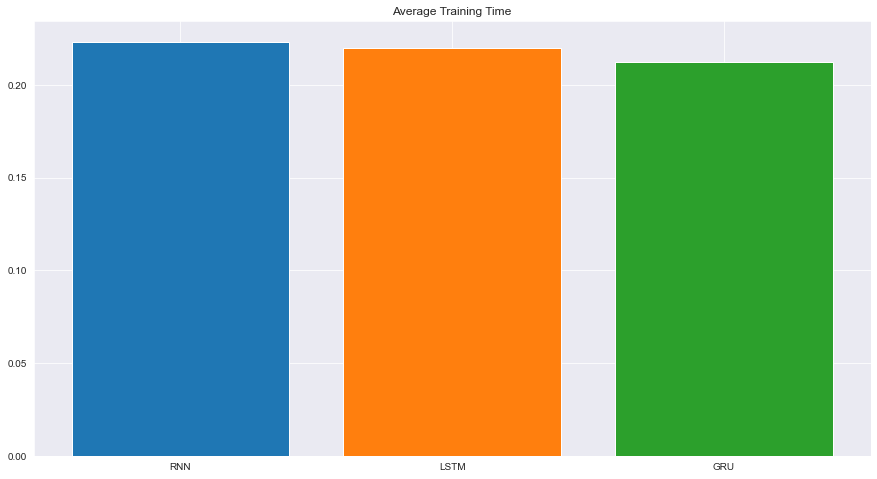

<Figure size 432x288 with 0 Axes>

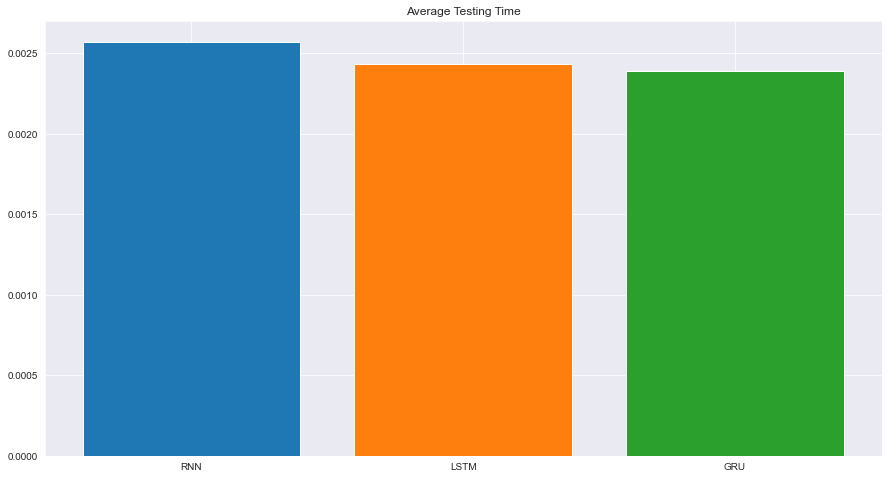

In [14]:
fig = plt.figure()
plt.figure(figsize=(15,8))
plt.title('Average Training Time')

for i in range(3):
    plt.bar([models[i]],model_times[i][0])

plt.show()

fig = plt.figure()
plt.figure(figsize=(15,8))
plt.title('Average Testing Time')

for i in range(3):
    plt.bar([models[i]],model_times[i][1])

plt.show()

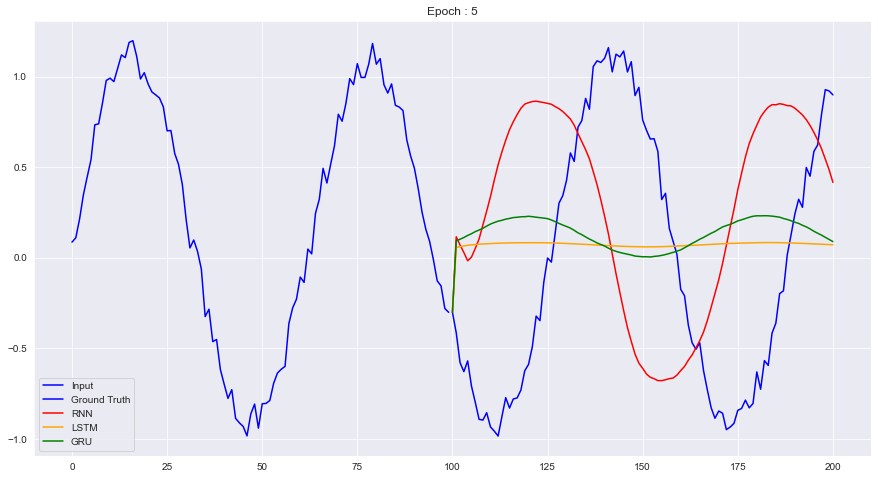

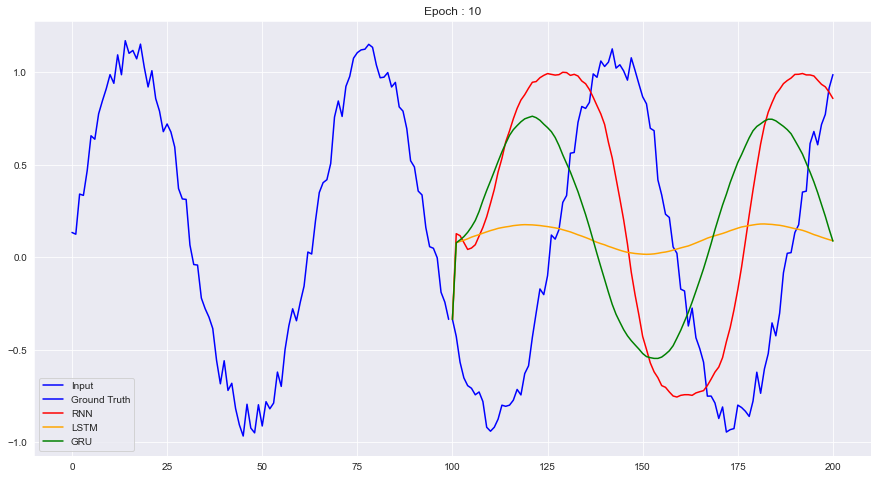

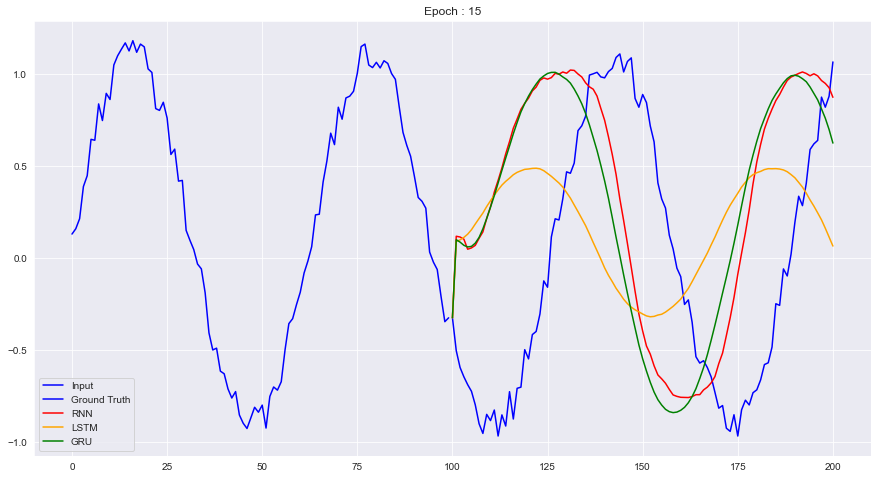

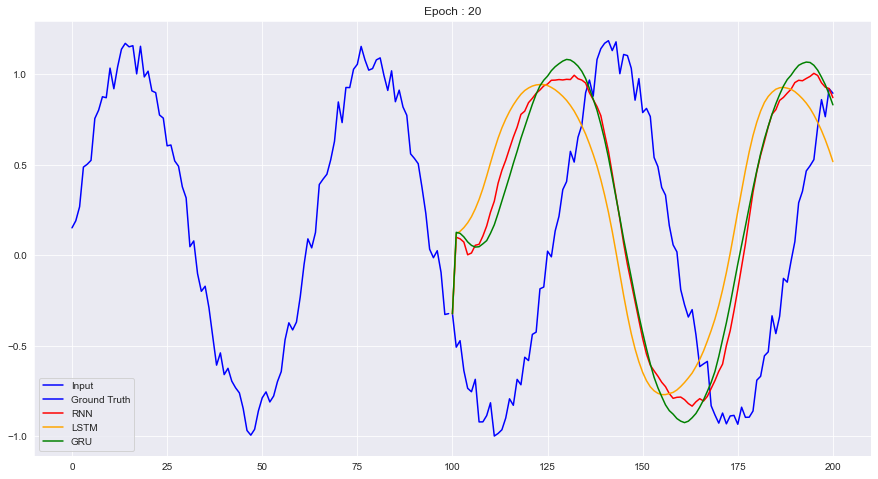

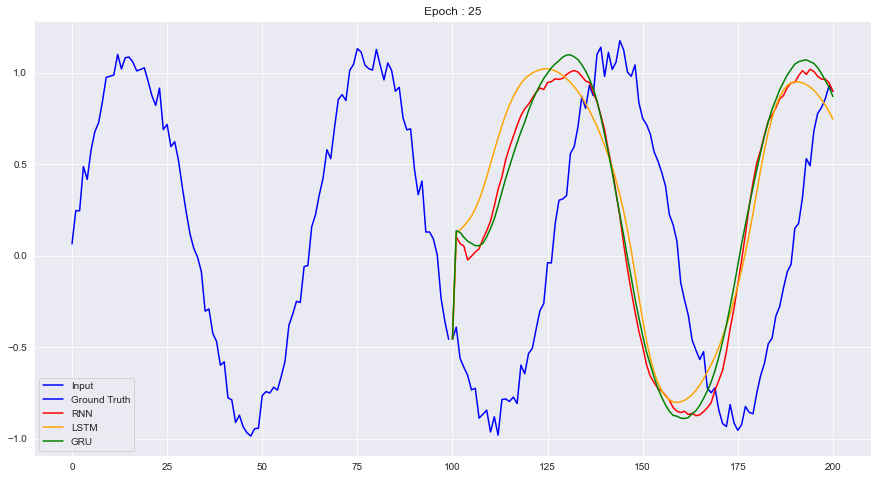

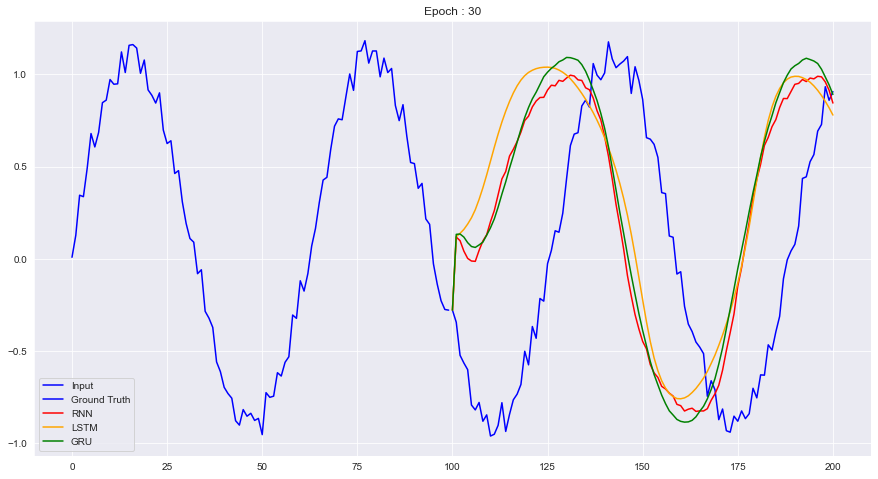

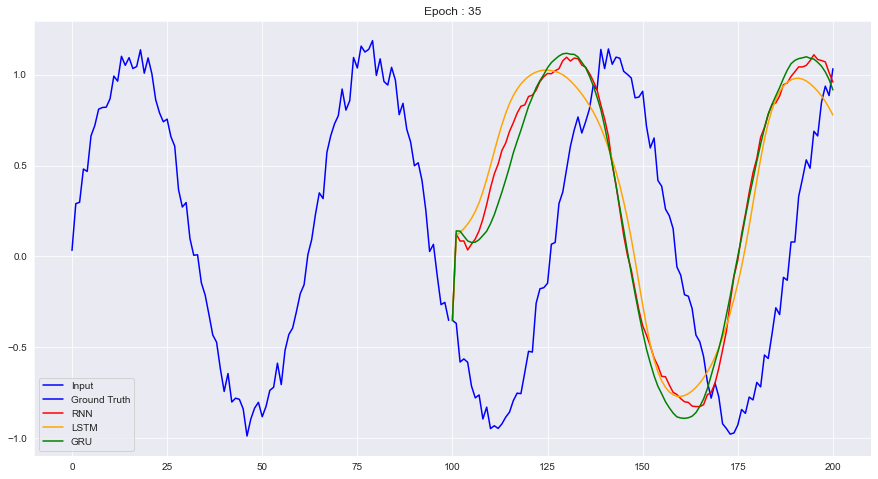

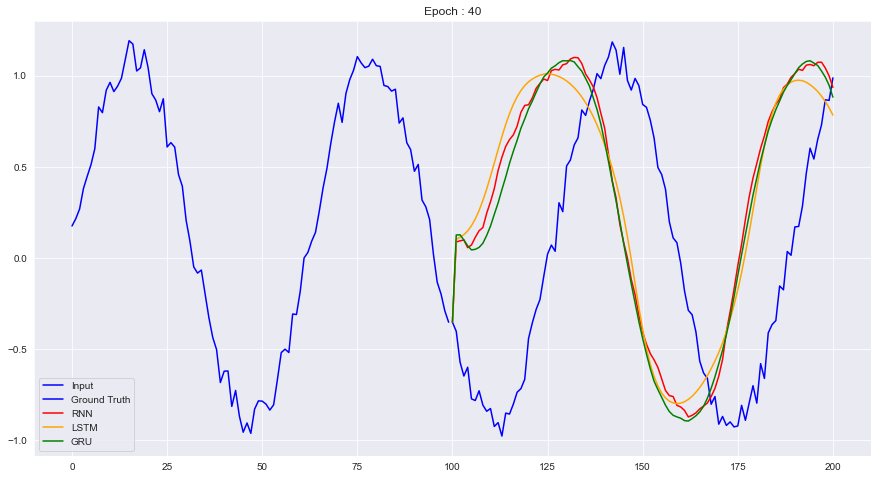

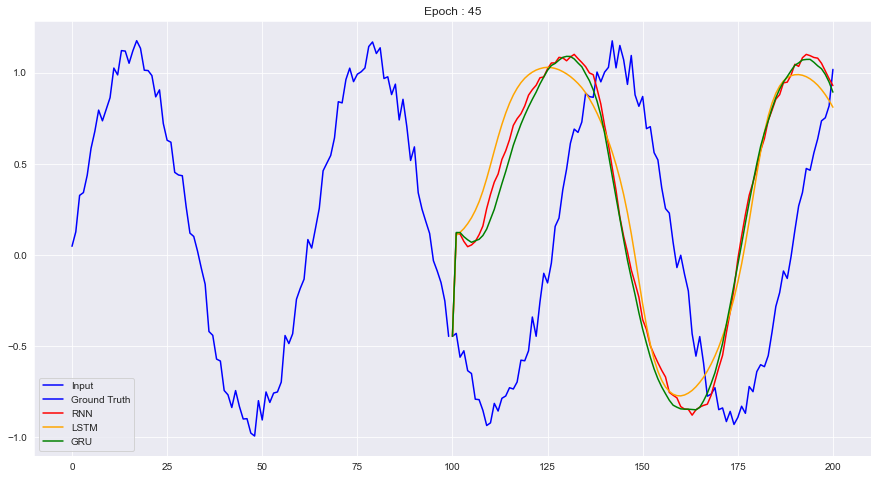

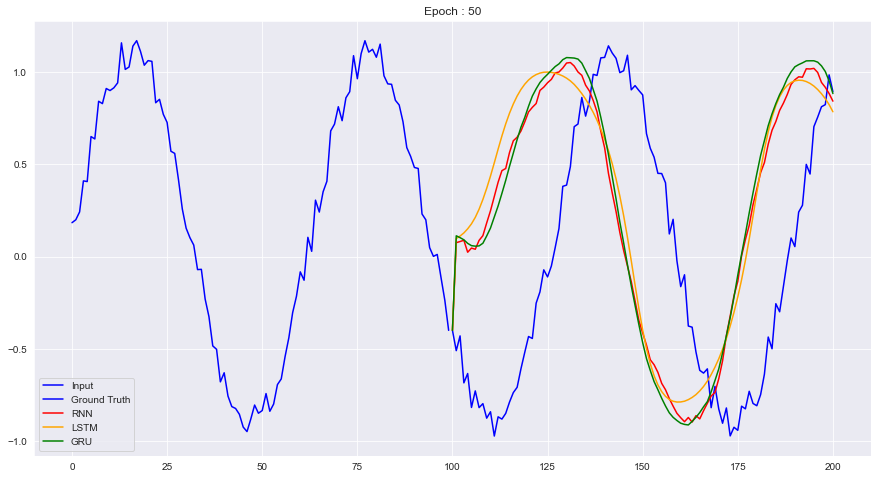

In [15]:
e = 0
prediction_len = len(model_predictions[0][0])
diff = int(prediction_len/10)

for nth_prediction in range(0,prediction_len,diff):
    e = e + 1
    fig = plt.figure(figsize=(15,8))
    plt.title(f'Epoch : {e*diff}')
    sns.lineplot(x = [i for i in range(test_dataset_size)],y = model_predictions[0][0][nth_prediction].reshape(test_dataset_size,),label = 'Input',color = 'blue')
    end_point = model_predictions[0][0][nth_prediction].reshape(test_dataset_size,)[-1:]
    sns.lineplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,model_predictions[0][1][nth_prediction][0]),label = 'Ground Truth',color = 'blue')
    for color , nth_model in zip(['red','orange','green'],[0,1,2]):
        sns.lineplot(x = [i for i in range(test_dataset_size,test_dataset_size*2+1)],y = np.append(end_point,model_predictions[nth_model][2][nth_prediction].reshape(test_dataset_size,)),linestyle='solid',label=f'{models[nth_model]}',color = color)
    plt.show()